<div markdown=1 class=Abstract> In this chapter we consider the problem of numerical computation of integrals. In one dimension, we present and analyze elementary quadrature rules, link them with polynomial interpolation, and see how they can be used to provide composite quadrature rules. Then, we present a non-deterministic approach to compute integrals which can easily be adapted to compute volumes in 3 dimensions. These methods are tested to solve three problems.

<div markdown=1 class=Abstract> The symbol [$\star$] indicates supplementary material (most of the time proofs) that is optional to understand. This material is provided for the sake of completeness and for interested readers.

## Table of contents

- [Introduction](#intro)
- [Elementary quadrature rules](#ElemQuad)
- [Composite integration](#CompQuad)
- [A non-deterministic approach](#MC)
- [Back to the case studies](#CS)

In [3]:
## loading python libraries

# necessary to display plots inline:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing 
import math

from scipy.integrate import newton_cotes # coefficients for Newton-Cotes quadrature rule
from scipy.special import roots_legendre # coefficients for Gauss-Legendre quadrature rule

from math import *              # package for mathematics (pi, arctan, sqrt, factorial ...)

<a id="intro"></a>
## Introduction

Suppose you want to compute the integral of a function $f$ on an interval $[a,b]$:

$$
\int_a^b f(x)dx
$$

and suppose that
- no explicit anti-derivative of $f$ is known,
- the values of $f$ are known for a discrete set of point $(x_k)_{k=0..n}$ in $[a,b]$.

Depending on the problem, the set of points $x_k$ at which we know $f$ might be given to us, or we might be able to chose it. In both of these cases, the integral cannot be computed exactly and one has to design a numerical method to estimate its value.

We give below three examples of situations where such a numerical approximation is needed.


### Case study 1: Manufacturing a corrugated roofing. 瓦楞屋顶曲线

We consider the following problem from the book *Numerical analysis* of R. Burden and J. Faires. 

><center>
<img src="./figures/CorrugatedSheet.png" alt="Corrugated Sheet" style="height: 200px;"/>
</center>

>A sheet of corrugated roofing is constructed by pressing a flat sheet of aluminum into one
whose cross section has the form of a sine wave. A corrugated sheet 48 inches long is needed, the height of each wave is 1 inch from the center
line, and each wave has a period of approximately $2\pi$ inches. 
>
>The problem of finding the length
of the initial flat sheet is one of determining the length of the curve given by $f (x) = \sin x$
from $x = 0$ inch to $x = 48$ inches. From calculus we know that this length is
>
>$$ l = \int_{0}^{48} \sqrt{1 + f'(x)^2}dx = \int_{0}^{48} \sqrt{1 + cos^2(x)}dx$$
>
>so the problem reduces to evaluating this integral. Although the sine function is one of
the most common mathematical functions, the calculation of its length involves an elliptic
integral of the second kind, which cannot be evaluated explicitly.

### Case study 2: Length of a race track

Suppose that a car laps a race track in 84 seconds and that one wants to compute the corresponding length of the track. If $v(t)$ is the velocity of the car at time $t$, we have that
$$
\text{Length} = \int_0^{84} v(t)dt.
$$

Unfortunately, we do not have at our disposal the velocity for all values of $t$. Indeed, we only have access to the speed of the car at each 6-second interval, determined by using a radargun and given in feet/second. The corresponding values are given below.

Time |  0 |   6|  12|  18|  24|  30|  36|  42|  48|  54|  60|  66|  72|  78|  84|
-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
Speed|124| 134| 148| 156| 147| 133| 180| 109| 99| 85| 78| 89| 104| 116| 123|

One needs to find a way to approximate the length of the track using these discrete values.

### Case study 3: Computing volumes of solids

Suppose you want to study the behavior of dry granular medium. Such a system is made of an assembly of solid particles, being subject to external forces such as gravity, an external fluid inter-particle forces or contact forces...

To model such a system, one has to write, for each of the particles, Newton's second law, which expresses the conservation of momentum. To do so, one has to estimate the forces and their momentum exerted on each of the particles. 

The first step to achieve this task is to be able to compute the mass of the particles. However, this mass depends both on the density of a particle and on its shape. If $B$ is the domain of the grain and $\rho$ its density, its mass is then given by: 

$$ \int_{B} \rho dxdydz =\rho\int_{B}dxdydz.$$

One can consider particles with various shapes $B$. In some simple cases, the integral can be computed explicitly. For example one can consider 
- **spherical particles:** each grain is a ball of radius $R$, that is,
$$
B = \left\{ (x,y,z)\in\mathbb{R}^3,\ \frac{x^2}{R^2} + \frac{y^2}{R^2} +\frac{z^2}{R^2} \leq 1 \right\}.
$$
This is the easiest way to represent the grain and you only need to find the volume of a ball, which is explicitly known:
$$
V = \frac{4}{3}\pi R^3.
$$
- **ellipsoidal particles:** each grain is an ellipsoid having principal axes of length $\frac{a}{2}$, $\frac{b}{2}$ and $\frac{c}{2}$, that is,
$$
B = \left\{ (x,y,z)\in\mathbb{R}^3,\ \frac{x^2}{a^2} + \frac{y^2}{b^2} +\frac{z^2}{c^2} \leq 1 \right\}.
$$
For $a=b=c=R$, one recovers the ball of radius $R$. In general, the volume of an ellipsoid is given by:
$$
V = \frac{4}{3}\pi a\,b\,c.
$$

- **super-ellipsoidal particles:** other more complicated shapes can be considered, for which no explicit formula is available for the volume. One example of families of shapes that can be considered is super-ellipsoidal shapes (see for instance https://en.wikipedia.org/wiki/Superellipsoid). Such shapes depend on two real parameters $e$ and $n$, 3 radii $a$, $b$, $c$, and a given by
$$
B = \left\{ (x,y,z)\in\mathbb{R}^3,\  \left(\left|\frac{x}{a}\right|^{\frac{2}{e}}+\left|\frac{y}{b}\right|^{\frac{2}{e}}\right)^{\frac{e}{n}}+\left|\frac{z}{c}\right|^{\frac{2}{n}}\leq 1 \right\}.
$$
For $e=n=1$, one recovers the ellipsoid of parameters $a$, $b$ and $c$. **The volume of such solids cannot be explicitly computed in general and one has to numerically estimate the integral.** Two examples of super-ellipsoids are plotted on the following figure:
<table>
        <tr>
            <td><img src="./figures/r1t05.png" alt="Superellipsoid 1" style="height: 300px;"/></td>
            <td><img src="./figures/r4t133.png" alt="Superellipsoid 2" style="height:300px;"/></td>
        </tr>
</table>

<a id="ElemQuad"></a>
## Elementary quadrature rules 基本弓形求积法

Suppose you want to compute 

$$
\int_a^b f(t)dt.
$$

Our goal is to find an approximation of that integral using a weighted sum of values of $f$.

<div markdown=1, class="Def"> 

A weighted sum of the form

$$
I^n_{[a,b]}(f) = \sum_{k=0}^n f(x_k)\omega_k
$$

is called an **elementary quadrature rule**, and is entirely determined by the pairs $(x_k,\omega_k)_{k=0..n}$, which are often represented in a table listing the values of these pairs:

\begin{array}{c|cccc}
x_k & x_0 & x_1 & \ldots & x_n \\ \hline
\omega_k & \omega_0 & \omega_1 & \ldots & \omega_n 
\end{array}

The integer $n$ is the **degree 级数** of the quadrature rule, the points $(x_k)_{k=0..n}$ are called the **nodes 节点** of the quadrature rule, and the coefficients $(\omega_k)_{k=0..n}$ its **weights 权重**.

<div  markdown=1 class="DoIt"> 

Complete the following cell to get a function `QuadRule` which evaluates such a quadrature rule $\sum_{k=0}^n f(x_k)\omega_k$. In the subsequent cell, use this function to check that the proposed nodes and weights give a quadrature rule which approximates $\int_{0}^{\pi}$ reasonably well, by choosing simple functions $f$ for which you can compute the integral by hand.

In [4]:
def QuadRule(f, x, w):
    """
    Approximate integral using a quadrature rule
    -----------------------------------------
    Inputs :
    f: function to be integrated
    x: 1D array containing the nodes [x_0,...,x_n]
    w: 1D array containing the weights [w_0,...,w_n]
    
    Output
    the value of f(x_0)*w_0 + ... + f(x_n)*w_n
    """
    return np.sum(f(x)*w)

In [5]:
# Some given nodes and weights for a quadrature formula approximating the integral between 0 and pi
x = np.array([0.354062724002813, 1.570796326794897, 2.787529929586980])
w = np.array([0.872664625997165, 1.396263401595464, 0.872664625997165]) #随意选取的节点

def ftest1(x):
    return np.sin(x)

I_f1 = QuadRule(ftest1, x, w)
print("For the function f(x) = sin(x), the integral is equal to 2, and the quadrature rule gives %.5f" % I_f1)

def ftest2(x):
    return np.exp(x)

I_f2 = QuadRule(ftest2, x, w)
I_2 = np.exp(np.pi) - 1
print("For the function f(x) = exp(x), the integral is equal to exp(pi)-1 = %.5f," % I_2, "and the quadrature rule gives %.5f" % I_f2)

For the function f(x) = sin(x), the integral is equal to 2, and the quadrature rule gives 2.00139
For the function f(x) = exp(x), the integral is equal to exp(pi)-1 = 22.14069, and the quadrature rule gives 22.13292


<div markdown=1 class='Rmk'>

Note that through the change of variable $t = a + \frac{x+1}{2}(b-a)$, an integral on $[a,b]$ can always be transformed into an integral on $[-1,1]$, and vice versa:

$$\int_a^bf(t)dt=\frac{b-a}{2}\int_{-1}^1 f\left(a + \frac{x+1}{2}(b-a)\right)dx.$$

Therefore, we can simply focus on quadrature rules on $[-1,1]$. Indeed, starting from a given quadrature rule on $[-1,1]$

$$
\int_{-1}^{1} f(x)dx \approx I^n_{[-1,1]}(f) = \sum_{k=0}^n f(x_k)\omega_k,
$$

the same change of variable yields

$$
\int_a^bf(x)dx \approx I^n_{[a,b]}(f) = \frac{b-a}{2}\sum_{k=0}^n \omega_k\, f\left(a + \frac{x_k+1}{2}(b-a)\right) = \sum_{k=0}^n f(\tilde x_k) \tilde \omega_k,$$

where

$$
\tilde x_k = a + \frac{x_k+1}{2}(b-a) \qquad{}\text{and}\qquad{} \tilde \omega_k = \frac{b-a}{2} \omega_k.
$$

The question which now arises is: how to chose the nodes and the weights to get a quadrature rule which approximates the integral well?

A natural way of approximating integrals is to replace $f$ by an approximation whose integral is easier to compute. Since the integral of polynomials is easy to compute, one can think of replacing $f$ by its Lagrange interpolation polynomial $P_n(f)$.

Consider $f: [-1,1]\to \mathbb{R}$ and $n+1$ interpolation nodes $(x_k)_{k=0..n}$ in $[-1,1]$. We recall that the interpolation polynomial $P_n(f)$ can be written

$$
P_n(f)(x) = \sum_{k=0}^n  f(x_k) L_k(x),
$$

where $(L_k)_{k=0..n}$ is the basis of elementary Lagrange polynomials given by 

$$ L_k(x) = \prod_{i \neq k}\frac{x - x_i}{x_k - x_i}, \quad{} 0 \leq k \leq n.$$

Then, the integral of $f$ on $[-1,1]$ can be approximated by

$$\int_{-1}^1 P_n(f)(x)dx = \int_{-1}^1 \sum_{k=0}^n  f(x_k) L_k(x) dx = \sum_{k=0}^n  \left(\int_{-1}^1 L_k(x) dx \right)f(x_k) .$$

Taking

$$
\omega_k = \int_{-1}^1 L_k(x) dx,
$$

the approximation of $f$ by $P_n(f)$ therefore yields a quadrature rule

$$
I^n_{[-1,1]}(f) = \int_{-1}^1 P_n(f)(x) dx = \sum_{k=0}^{n}\omega_k\,f(x_k),
$$

which can be used to approximate $\int_{-1}^1 f(x) dx$.




<div  markdown=1 class="Def"> 

Consider $n+1$ interpolation nodes $(x_k)_{k=0..n}$ in $[-1,1]$. The quadrature rule $I^n_{[-1,1]}$ defined by


$$
I^n_{[-1,1]}(f) = \sum_{k=0}^{n}\omega_k\,f(x_k), \qquad{} \omega_k = \int_{-1}^1 L_k(x) dx,
$$

is called the **quadrature rule based on Lagrange interpolation 拉格朗日上的弓形积分** (associated to the nodes $(x_k)_{k=0..n}$).

We are going to study specific examples of quadrature rules obtained this way in a moment, but let us first discuss some general properties.

### First error estimates for quadrature rules based on Lagrange interpolation

<div  markdown=1 class="Thm"> 

Consider $f: [-1,1]\to \mathbb{R}$, and for all $n\in\mathbb{N}$, $n+1$ interpolation nodes $(x_k)_{k=0..n}$ in $[-1,1]$ together with the quadrature rule $I^n_{[-1,1]}$ based on Lagrange interpolation for those nodes. If the interpolation polynomial $P_n(f)$ converges uniformly to $f$ on $[-1,1]$, i.e. if

$$
\sup_{x\in[-1,1]} |f(x) - P_n(f)(x)| \rightarrow 0 \quad{} \text{when} \quad{} n\rightarrow \infty,
$$

then

$$I^n_{[-1,1]} (f) \rightarrow  \int_{-1}^1 f(x) dx  \quad{} \text{when} \quad{} n\rightarrow \infty.
$$ 

<div  markdown=1 class="DoIt"> Prove the previous theorem.

>**Proof.** 
>
>Since we have 
$$I^n_{[-1,1]}(f) = \int_{-1}^1 P_n(f)(x) dx= \sum_{k=0}^{n}\omega_k\,f(x_k)$$
> Therefore we know that
>\begin{align}
\left\vert \int_{-1}^1 f(x) dx  -  I^n_{[-1,1]} (f) \right\vert &= \left\vert \int_{-1}^1 f(x) dx  - \int_{-1}^1 P_n(f)(x) dx  \right\vert \\
&\leq  \int_{-1}^1 \left\vert f(x) - P_n(f)(x)\right\vert dx   \\
&\leq \left(\sup_{x\in[-1,1]} \left\vert f(x) - P_n(f)(x)\right\vert \right)\left( \int_{-1}^{1} 1 dx\right) \\
&= 2 \sup_{x\in[-1,1]} \left\vert f(x) - P_n(f)(x)\right\vert,
\end{align}
>
>Since we have
$$I^n_{[-1,1]} (f) \rightarrow  \int_{-1}^1 f(x) dx  \quad{} \text{when} \quad{} n\rightarrow \infty.$$
> Therefore the upper bound tends to 0 as n tends to infinity

If we want to study the error for a given value of $n$, we can use the error estimates that we obtained in the previous chapter on $P_n(f)$.

<div  markdown=1 class="Thm"> 

Let $f : [-1,1] \to \mathbb{R}$ be $n+1$ times differentiable, and $x_0,\ldots,x_n$ be $n+1$ distinct interpolations nodes in $[-1,1]$. Consider the quadrature rule $I^n_{[-1,1]}$ based on Lagrange interpolation. Then

$$\left\vert  \int_{-1}^1 f(x) dx - I^n_{[-1,1]} (f) \right\vert  \leq  \frac{2\sup_{x\in [-1,1]} \left\vert \Pi_{x_0,\ldots,x_n}(x) \right\vert }{(n+1)!} \sup_{x\in [-1,1]} \left\vert f^{(n+1)}(x) \right\vert, 
$$ 

where

$$
\Pi_{x_0,\ldots,x_n}(x) = (x-x_0)(x-x_1)\cdots(x-x_n).
$$

>**Proof.** We start again by writing
>
>\begin{align}
\left\vert \int_{-1}^1 f(x) dx  -  I^n_{[-1,1]} (f) \right\vert &= \left\vert \int_{-1}^1 f(x) dx  - \int_{-1}^1 P_n(f)(x) dx  \right\vert \\
&\leq  \int_{-1}^1 \left\vert f(x) - P_n(f)(x)\right\vert dx,
\end{align}
>
>and then use that (see the previous chapter) 我们从chap2得到的结果
>
>$$ \left\vert f(x) - P_n(f)(x) \right\vert \leq \frac{\sup_{x\in [-1,1]} \left\vert \Pi_{x_0,\ldots,x_n}(x) \right\vert }{(n+1)!} \sup_{x\in [-1,1]} \left\vert f^{(n+1)}(x) \right\vert,
$$
>
>which yields
>
>>\begin{align}
\left\vert \int_{-1}^1 f(x) dx  -  I^n_{[-1,1]} (f) \right\vert &\leq  \frac{\sup_{x\in [-1,1]} \left\vert \Pi_{x_0,\ldots,x_n}(x) \right\vert }{(n+1)!} \sup_{x\in [-1,1]} \left\vert f^{(n+1)}(x) \right\vert \int_{-1}^1 1dx \\
&= \frac{2\sup_{x\in [-1,1]} \left\vert \Pi_{x_0,\ldots,x_n}(x) \right\vert }{(n+1)!} \sup_{x\in [-1,1]} \left\vert f^{(n+1)}(x) \right\vert.
\end{align}

<div  markdown=1 class="Rmk">

If we consider a general interval $[a,b]$, and the corresponding quadrature rule $I^n_{[a,b]}$, this error estimate writes

$$\left\vert  \int_{a}^b f(x) dx - I^n_{[a,b]} (f) \right\vert  \leq \left(\frac{b-a}{2}\right)^{n+2} \, \frac{2\sup_{x\in [-1,1]} \left\vert \Pi_{x_0,\ldots, x_n}(x) \right\vert }{(n+1)!} \sup_{x\in [a,b]} \left\vert f^{(n+1)}(x) \right\vert.
$$ 

### Degree of accuracy

Another notion that can be helpful in measuring the *quality* of a quadrature rule is the **degree of accuracy**.

<div  markdown=1 class="Def"> 



Consider any quadrature rule

$$
I^n_{[-1,1]} (f) = \sum_{k=0}^n f(x_k) \omega_k.
$$

If this quadrature rule is **exact** for all polynomials of degree $n_a$ or less, i.e.

$$
I^n_{[-1,1]} (Q) = \int_{-1}^1 Q(x) dx \quad{} \text{for all polynomial }Q\text{ of degree }n_a\text{ or less},
$$

then the quadrature rule is said to have a **degree of accuracy of at least $n_a$**. If there also exists a polynomial of degree $n_a+1$ for which the quadrature rule is not exact, i.e.

$$
I^n_{[-1,1]} (Q) \neq \int_{-1}^1 Q(x) dx \quad{} \text{for a polynomial }Q\text{ of degree }n_a+1,
$$

then the **degree of accuracy is equal to $n_a$**.

<div  markdown=1 class="Prop"> 

Consider $n+1$ interpolation nodes $x_0,\ldots,x_n$ in $[-1,1]$.

- The associated quadrature rule $I^n_{[-1,1]}$ based on Lagrange interpolation has a degree of accuracy of at least $n$.

- Reciprocally, if a quadrature rule with $n+1$ nodes $I^n_{[-1,1]} (f) = \sum_{k=0}^n f(x_k) \omega_k$ has a degree of accuracy of at least $n$, then it must be the quadrature rule based on Lagrange interpolation.

> **Proof.** 
>- For any polynomial $Q$ of degree $n$ or less, one has $P_n(Q)=Q$ by uniqueness of the Lagrange interpolation polynomial. Therefore, if we consider the quadrature rule based on Lagrange interpolation, for any such polynomial $Q$ we have
>$$
I^n_{[-1,1]}(Q) = \int_{-1}^1 P_n(Q)(x) dx = \int_{-1}^1 Q(x) dx,
$$
> and the quadrature rule has indeed a degree of accuracy of at least $n$.
>- Reciprocally, let us consider a quadrature rule $I^n_{[-1,1]} (f) = \sum_{k=0}^n f(x_k) \omega_k$ having a degree of accuracy of at least $n$. The Lagrange elementary polynomials
>$ $
>$$ L_j(x) = \prod_{i \neq j}\frac{x - x_i}{x_j - x_i}$$
>$ $
>are of degree $n$, therefore the quadrature rule is exact for them:
>$ $
>$$
I^n_{[-1,1]} (L_j) = \sum_{k=0}^n L_j(x_k) \omega_k = \int_{-1}^1 L_j(x) dx.
$$
> However, for each elementary Lagrange polynomial we have
$$
L_j(x_k) = 
\left\{
\begin{aligned}
&1 \quad{} & j=k, \\
&0 \quad{} & j\neq k,\\
\end{aligned}
\right.
$$
> therefore we get 
>$$
\omega_j = \int_{-1}^1 L_j(x) dx,
$$
which are the weights of the quadrature rule based on Lagrange interpolation.

The degree of accuracy allows us to get another error estimate for quadrature rules.

<div  markdown=1 class="Thm"> 

Let $I^n_{[-1,1]}$ be an elementary quadrature rule on $[-1,1]$, written as

$$
I^n_{[-1,1]}(f) = \sum_{k=0}^n \omega_k f(x_k),
$$

and having a degree of accuracy of at least $n_a$. Then, for any function $f\in \mathcal{C}^{n_a+1}([-1,1])$, we have

$$
\left\vert \int_{-1}^{1} f(x)dx - I^n_{[-1,1]}(f)\,\right\vert \leq \frac{2+\sum_{k=0}^n |\omega_k| }{(n_a+1)!}\sup_{x\in [-1,1]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert.
$$

>**Proof.** The main idea is to approach $f$ by its Taylor expansion of degree $n_a$, for which the quadrature rule is exact. Introducing
>
>$$
Q_{n_a}(x) = f(0) + f'(0)x + \ldots + \frac{f^{(n_a)}(0)}{n_a !}x^{n_a},
$$
>
>Taylor-Lagrange formula yields
>
>$$
\forall x\in [-1,1],\quad{} \left\vert  f(x) - Q_{n_a}(x)\right\vert \leq \frac{1}{(n_a+1)!} \sup_{x\in[-1,1]}\left\vert \,f^{(n_a+1)}(x)\,\right\vert.
$$
>
>Moreover, since $Q_{n_a}$ is a polynomial of degree at most $n_a$, $\int_{-1}^1 Q_{n_a}(x)dx = I^n_{[-1,1]}(Q_{n_a})$, which means we have
>
>\begin{align}
\left\vert \int_{-1}^1 f(x)dx - I^n_{[-1,1]}(f)\,\right\vert &= \left\vert \int_{-1}^1 \left(f(x) - Q_{n_a}(x) \right)dx - I^n_{[-1,1]}(f - Q_{n_a})\,\right\vert \\
&\leq \int_{-1}^1 \left\vert f(x) - Q_{n_a}(x) \right\vert dx + \sum_{k=0}^n \vert \omega_k\vert \left\vert f(x_k)-Q_{n_a}(x_k)\right\vert \\
&\leq \left(2 + \sum_{k=0}^n |\omega_k| \right) \sup_{x\in[-1,1]} \left\vert f(x) - Q_{n_a}(x) \right\vert\\
&\leq \frac{2 + \sum_{k=0}^n \vert\omega_k\vert }{(n_a+1)!}  \sup_{x\in[-1,1]}\left\vert\,f^{(n_a+1)}(x)\,\right\vert.
\end{align}

<div  markdown=1 class="Rmk">

- As soon as the quadrature rule has a degree of accuracy of at least $0$, we have
$$
I^n_{[-1,1]}(1) = \sum_{k=0}^n \omega_k = \int_{-1}^1 1 dx = 2.
$$
In principle, we would like all the weights $\omega_k$ to be nonnegative. Otherwise, $I^n_{[-1,1]}(f)$ could be negative for a nonnegative function $f$. The above estimate also suggests that it could be beneficial for all the weights to be nonnegative. Indeed, the term $\sum_{k=0}^n \vert\omega_k\vert$ would then simply be equal to 2, whereas having some negative weights could lead to $\sum_{k=0}^n \vert\omega_k\vert$ being much larger.

- If we consider a general interval $[a,b]$, and the corresponding quadrature rule $I^n_{[a,b]}$, the error estimate based on the degree of accuracy writes
$$
\left\vert \int_{a}^{b} f(x)dx - I^n_{[a,b]}(f)\,\right\vert \leq \left(\frac{b-a}{2}\right)^{n_a+2}\, \frac{2+\sum_{k=0}^n |\omega_k|}{(n_a+1)!} \sup_{x\in [a,b]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert.
$$
Notice that the main difference compared to the previous estimate we obtained using the error for Lagrange interpolation is the scaling with respect to the length $b-a$ of the interval. Here we have $(b-a)^{n_a+2}$, instead of $(b-a)^{n+2}$ for the other estimate.

### Newton-Cotes quadrature rules 牛顿-柯特斯公式

<table>
        <tr>
            <td><img src="figures/Newton.jpg" alt="Newton" style="width: 230px;" /></td>
            <td><img src="figures/Cotes.jpeg" alt="Cotes" style="width: 190px;" /></td>
        </tr>
</table>

>**Isaac Newton (1643 – 1727) and Roger Cotes (1682 - 1716).**
> English mathematician, astronomer, theologian, author and physicist, Isaac Newton made breaking contributions to classical mechanics, optic and also contributed to infinitesimal calculus. Roger Cotes is an English mathematician known for closely working with Isaac Newton with whom he shares the discovery of the Newton-Cotes quadrature formulas for approximating integrals. This method extends the older rectangular and trapezoidal rules and is based on Lagrange polynomial interpolation on equidistant nodes.

<div markdown=1 class="Def"> 

The **Newton-Cotes quadrature rules** are the quadrature rules based on Lagrange interpolation with equidistant points. 牛顿-柯特斯公式是基于拉格朗日插值法以及等距插值上的

#### First examples and geometrical interpretation

- **Left rectangle rule**

The very first method that can be designed uses 1 point. In that case, the unique node can be freely chosen. For example, it can be set to the left bound of the interval, giving $n=0$, $x_0=-1$ and $P_0(x)=f(x_0)$. The corresponding approximation of the integral is

$$
\int_{-1}^1f(x)dx \approx \int_{-1}^1 P_0(x)dx = 2 f(x_0),
$$

and the elementary rule is described by
\begin{array}{c|c}
x_k & -1 \\ \hline
\omega_k& 2
\end{array}

This method is called the **left rectangle rule** since it approximate the integral of $f$ by the area of the rectangle based on the point $(x_0,f(x_0))$:

<img src="./figures/RectL_Elem.png" alt="RectL Elem" style="height: 300px;"/>

- **Mid-point rule**

For $n=0$, another choice for the node could be the middle of the interval: $x_0=0$, leading to the rule

\begin{array}{c|c}
x_k & 0 \\ \hline
\omega_k& 2
\end{array}

<img src="./figures/MP_Elem.png" alt="MP Elem" style="height: 300px;"/>

- **Trapezoidal rule**

For $n=1$, the choice of equidistant nodes leads to $x_0=-1$ and $x_1=1$. The corresponding Lagrange interpolation polynomial is then given by

\begin{align}
P_1(f)(x) &= f(x_0)\frac{x-x_1}{x_0-x_1}+f(x_1)\frac{x-x_0}{x_1-x_0}.
\end{align}

\begin{align}
P_1(f)(x) = \frac{f(x_{1})-f(x_{0})}{x_{1}-x_{0}}x+\frac{f(x_{0})x_{1}-f(x_{1})x_{0}}{x_{1}-x_{0}}.
\end{align}

<img src="./figures/Trap_Elem.png" alt="Trap Elem" style="height: 300px;"/>

<div markdown=1 class="DoIt">

Compute the weights associated to this quadrature rule, and complete the table just below.

<div markdown=1 class="remark"

<div markdown=1 class="Answer">

First we plugin $x_0=-1$ and $x_1=1$ we have
\begin{align}
P_1(f)(x) &= f(x_0)\frac{x-x_1}{x_0-x_1}+f(x_1)\frac{x-x_0}{x_1-x_0}\\
          &= f(x_1)\frac{x+1}{2}-f(x_0)\frac{x-1}{2}
\end{align}

Then we compute the integral of the polynominla
\begin{align}
\int_{-1}^1 P_1(f)(x)dx &= -f(x_0) \int_{-1}^1 \frac{x-1}{2} dx + f(x_1)\int_{-1}^1 \frac{x+1}{2} dx = f(x_0) + f(x_1),
\end{align}


This quadrature rule is thus described by
\begin{array}{c|cc}
x_k & -1 & 1 \\ \hline
\omega_k& 1 & 1
\end{array}

- **Simpson's rule**

For $n=2$, the choice of equidistant nodes leads to $x_0=-1$, $x_1=0$ and $x_2=1$. The corresponding Lagrange interpolation polynomial is then given by

$$
P_2(f)(x)=f(x_0)\frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)}+f(x_1)\frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)}+f(x_2)\frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)},
$$

and the corresponding approximation is

$$
\int_{-1}^1f(x)dx \approx \int_{-1}^1 P_2(f)(x)dx = \frac{1}{3}f(-1) + \frac{4}{3}f(0)+ \frac{1}{3}f(1).
$$

This quadrature rule is thus described by
\begin{array}{c|cc}
x_k & -1 & 0 & 1 \\ \hline
\omega_k& \frac{1}{3} & \frac{4}{3} & \frac{1}{3}
\end{array}

<img src="./figures/Simpson_Elem.png" alt="Simpson Elem" style="height: 300px;"/>

<div markdown=1 class='DoIt'>

Fill the following cell to create the arrays $x$ and $w$ associated to each of the above-mentioned elementary quadrature rules.

In [6]:
# Left rectangle rule
x_LR = np.array([-1])
w_LR = np.array([2])

# Mid-point rule
x_MP = np.array([0])
w_MP = np.array([2])

# Trapezoidal rule
x_T = np.array([-1, 1])
w_T = np.array([1, 1])

# Simpson's rule
x_S = np.array([-1, 0, 1])
w_S = np.array([1/3, 4/3, 1/3])

#### Degree of accuracy

<div markdown=1 class='DoIt'>

Using the two cells below, give the degree of accuracy of each of the quadrature rules. How does this degree of accuracy compare to the degree $n$ of the interpolation polynomial on which the rule is based (or equivalently, to the number $n+1$ of nodes used)?

In [7]:
def test_exactness(x, w, deg_max):
    """
    Numerically checks up to which degree a give quadrature rule on [-1,1] is exact
    -----------------------------------------------------
    Inputs :
    x, w: 1D array representing the quadrature rule (x=nodes and w=weights)
    deg_max : maximal degree to be checked
    
    Output :
    comparison between int_{-1}^1 x^k and the quadrature rule applied to x^k, for k=0,...,deg_max
    """
    for k in np.arange(0, deg_max+1):
        theoretical_k = (1-(-1)**(k+1))/(k+1) # the exact value of int_{-1}^1 x^k
        quad_k = QuadRule(lambda t: t**k, x, w) # the approximate value of int_{-1}^1 x^k given by the quadrature rule
        print('int[-1,1] x^',k,' : exact value (4 digits) = ',"{:.4f}".format(theoretical_k), ', quadrature (4 digits) = ',"{:.4f}".format(quad_k),sep='')    
    return

In [8]:
print('Left rectanlge rule:')
test_exactness(x_LR, w_LR, 1)

print('\nMid-point rule:')
test_exactness(x_MP, w_MP, 2)

print('\nTrapeziodal rule:')
test_exactness(x_T, w_T, 2)

print("\nSimpson's rule:")
test_exactness(x_S, w_S, 4)

Left rectanlge rule:
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = -2.0000

Mid-point rule:
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 0.0000

Trapeziodal rule:
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 2.0000

Simpson's rule:
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 0.6667
int[-1,1] x^3 : exact value (4 digits) = 0.00

<div markdown class="Rmk">
    
Consider any quadrature rule

$$
I^n_{[-1,1]} (f) = \sum_{k=0}^n f(x_k) \omega_k.
$$

If this quadrature rule is **exact** for all polynomials of degree $n_a$ or less, i.e.

$$
I^n_{[-1,1]} (Q) = \int_{-1}^1 Q(x) dx \quad{} \text{for all polynomial }Q\text{ of degree }n_a\text{ or less},
$$
   

<div markdown=1 class='Answer'>

By linearity, checking that 

$$
\int_{-1}^1 x^k dx = I_{[-1,1]}(x^k) \quad{} \text{for }k=0,\ldots,K,
$$

for a given quadrature rule $I_{[-1,1]}$, is enough to ensure that

$$
\int_{-1}^1 Q(x) dx = I_{[-1,1]}(Q) \quad{} \text{for all polynomial }Q\text{ of degree at most K}.
$$

The above computations suggest that
- for the left rectangle rule, the degree of accuracy is $0$,
- for the mid-point rule, the degree of accuracy is $1$,
- for the trapezoidal rule, the degree of accuracy is $1$,
- for the Simpson rule, the degree of accuracy is $3$.

Since these quadrature rules are based on Lagrange interpolation, we already knew that their degree of accuracy what at least $n$ (where $n+1$ is the number of nodes used). In some cases (left rectangle and trapezoidal rule) the degree of accuracy is actually equal to $n$ , but in some others (mid-point and Simpson's rule) the degree of accuracy is in fact equal to $n+1$. **对于有$n$个数值点运用的多项式，则degree of accuracy是$n-1$或者$n$**

The appearance of this extra degree of accuracy in some cases is explained by the following proposition.

<div  markdown=1 class="Prop"> 

Consider $n+1$ interpolation nodes $x_0<\ldots<x_n$ in $[-1,1]$, and the associated quadrature rule $I^n_{[-1,1]}$ based on Lagrange interpolation (which we already know has a degree of accuracy of at least $n$). If $n$ is even, and the nodes are symmetric with respect to $0$, then the rule has a degree of accuracy of at least $n+1$. 

如果点的选取是关于零点对称，例如$-1,0,1$则是关于零点对称，并且多项式的级数n是偶数，则最后的degreey of accuracy是$n+1$, 否则是$n$

>**Proof. $[\star]$** We already know that the rule has a degree of accuracy of at least $n$, therefore it suffices to prove that 
>
>$$I^n_{[-1,1]}\left( x^{n+1}\right) = \int_{-1}^1 x^{n+1} dx .$$
>
>The integral is equal to $0$ because $n+1$ is odd, and therefore we have to prove that 
>
>$$ I^n_{[-1,1]}\left( x^{n+1}\right) = \sum_{k=0}^n \omega_k (x_k)^{n+1} = 0. $$
>
> Since $n$ is even, we can write $n=2m$ and split the sum
>
>\begin{align}
I^n_{[-1,1]}\left( x^{n+1}\right) &= \sum_{k=0}^{m-1} \omega_k (x_k)^{n+1} + \omega_m (x_m)^{n+1} + \sum_{k=m+1}^{n} \omega_k (x_k)^{n+1} \\
&= \omega_m (x_m)^{n+1} + \sum_{k=0}^{m-1} \left(\omega_k (x_k)^{n+1} +   \omega_{n-k} (x_{n-k})^{n+1} \right) .
\end{align}
>
> By assumption, the nodes are symmetric with respect to $0$, meaning that $x_k = - x_{n-k}$ for $k=0,\ldots,m-1$ and $x_m=0$, therefore
>
>\begin{align}
I^n_{[-1,1]}\left( x^{n+1}\right) = \sum_{k=0}^{m-1} \left(\omega_k - \omega_{n-k} \right)(x_{n-k})^{n+1}  .
\end{align}
>
> Besides, still using the symmetry assumption, we have for $k=0,\ldots,m-1$
>
>\begin{align}
L_k(x) & = \prod_{\substack{ 0\leq j \leq 2m \\ j\neq k}} \frac{x-x_j}{x_k-x_j} \\
&= \left( \prod_{\substack{ 0\leq j \leq m-1 \\ j\neq k}} \frac{x-x_j}{x_k-x_j}\frac{x-x_{n-j}}{x_k-x_{n-j}} \right) \frac{x-x_m}{x_k-x_m} \frac{x-x_{n-k}}{x_k-x_{n-k}} \\
&= \left( \prod_{\substack{ 0\leq j \leq m-1 \\ j\neq k}} \frac{x+x_{n-j}}{-x_{n-k}+x_{n-j}}\frac{x+x_{j}}{-x_{n-k}+x_{j}} \right) \frac{x}{-x_{n-k}} \frac{x+x_{k}}{-x_{n-k}+x_{k}}\\
&= \left( \prod_{\substack{ 0\leq j \leq m-1 \\ j\neq k}} \frac{-x-x_{n-j}}{x_{n-k}-x_{n-j}}\frac{-x-x_{j}}{x_{n-k}-x_{j}} \right) \frac{-x}{x_{n-k}} \frac{-x-x_{k}}{x_{n-k}-x_{k}}\\
& = \prod_{\substack{ 0\leq j \leq 2m \\ j\neq n-k}} \frac{-x-x_j}{x_k-x_j} \\
&= L_{n-k}(-x).
\end{align}
>
>This shows that for $k=0,\ldots,m-1$
>
>$$ \omega_k = \int_{-1}^1 L_k(x)dx = \int_{-1}^1 L_{n-k}(x)dx = \omega_{n-k}.$$
>
>Finally, we get
>\begin{align}
I^n_{[-1,1]}\left( x^{n+1}\right) = \sum_{k=0}^{m-1} \left(\omega_k - \omega_{n-k} \right)(x_{n-k})^{n+1}  =0,
\end{align}
>
>which ends the proof.


Coming back to our elementary Newton-Cotes quadrature rules, the situation can be summarized in the following table:

elementary rule  | degree $n$  | symmetry and $n$ even | degree of accuracy $n_a$
:---:|:--------:|:-:|:---:
Left rectangle | $n=0$| no | $n_a = 0$
Mid-point | $n=0$| yes | $n_a = 1$
Trapezoidal| $n=1$| no | $n_a = 1$
Simpson| $n=2$| yes | $n_a = 3$

#### Test

<div markdown=1 class='DoIt'>

Use these Newton-Cotes quadrature rules to approximate

$$
\int_{-1}^1 \cos\left(\frac{\pi}{2} x\right) dx = \frac{4}{\pi}.
$$

What could we try to get more precise results?

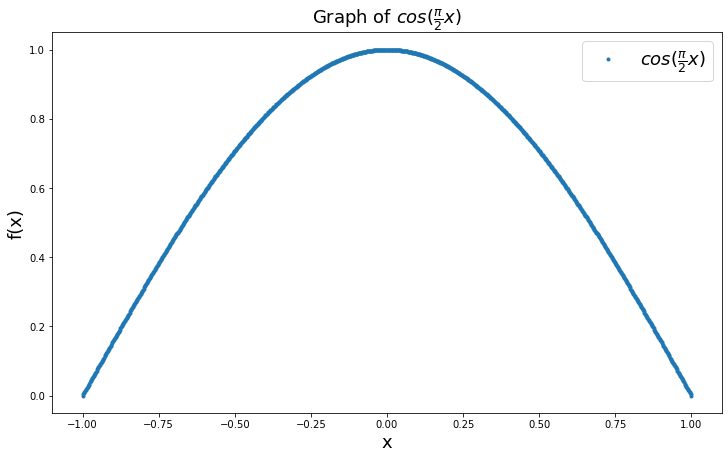

For the function f(x) = cos(pi/2 x), the integral between -1 and 1 is equal to 4\pi = 1.27323954


In [9]:
def f(x):
    return  np.cos(pi/2*x)
I = 4/pi

x = np.linspace(-1,1,1000)
y = f(x)
figure =  plt.figure(figsize=(12, 7))
plt.plot(x, f(x), marker='.', linestyle='', label = r'$cos(\frac{\pi}{2}x)$')
plt.legend(fontsize = 18)
plt.xlabel('x', fontsize = 18)
plt.ylabel('f(x)', fontsize = 18)
plt.title(r'Graph of $cos(\frac{\pi}{2}x)$', fontsize = 18)
plt.show()

print("For the function f(x) = cos(pi/2 x), the integral between -1 and 1 is equal to 4\pi = %.8f" %I)

In [10]:
I_LR = QuadRule(f, x_LR, w_LR) # approximation using the left rectangle rule
I_MP = QuadRule(f, x_MP, w_MP) # approximation using the mid-point rule
I_T = QuadRule(f, x_T, w_T) # approximation using the trapezoidal rule
I_S = QuadRule(f, x_S, w_S) # approximation using Simpson's rule

print("Approximation of the integral using the left rectangle quadrature rule : %.5f" % I_LR)
print("Approximation of the integral using the mid-point quadrature rule : %.5f" % I_MP)
print("Approximation of the integral using the trapezoidal quadrature rule : %.5f" % I_T)
print("Approximation of the integral using Simpson's quadrature rule : %.5f" % I_S)

Approximation of the integral using the left rectangle quadrature rule : 0.00000
Approximation of the integral using the mid-point quadrature rule : 2.00000
Approximation of the integral using the trapezoidal quadrature rule : 0.00000
Approximation of the integral using Simpson's quadrature rule : 1.33333


<div markdown=1, class="Answer">

These first quadrature rules and also the trapezoidal quadrature rules give results which are very far off the exact value of the integral, with only Simpson's rule being decent here (the relative error is still of roughly 5% in that case). In order to get more precise results with these Newton-Cotes rules, one could try to increase the number of nodes (which we are going to do now) or to split the interval into smaller subintervals (we study this option later in the notes).

#### Newton-Cotes formula of higher degree $n$ 牛顿-柯特斯公式对于更高级多项式的运用

For Newton-Cotes quadrature rules with larger values of $n$, computing by hand the values of the weights $w_k$ starts to be somewhat painful, but fortunately we can get them from an existing python function. 

In [11]:
def coeffs_NewtonCotes(n):
    """
    computation of the nodes and weights for the Newton-Cotes quadrature rule at any order
    ---------------------------------
    Inputs :
    n: degree of the rule (we want n+1 nodes)
    
    Outputs:
    x, w: 1D array containing the nodes and the weights
    """
    if n==0: # we take the mid-point rule 
        x = np.array([0.])
        w = np.array([2.])
    else:
        x = np.linspace(-1, 1, n+1) # n+1 equidistant nodes
        w, err = newton_cotes(n, equal=1) # Using the newton_cotes funtion from scipy.integrate (does not work for n=0)
        w = w*2/n # rescaling, scipy's function gives the weights for nodes in [0,n] rather than [-1,1]
    return x, w

<div markdown=1 class="DoIt">

Have a look at the weights for the first few values of $n$. What seems to happens when $n\geq 10$?

In [12]:
np.set_printoptions(precision=1) #to print less digits and have everyhting fitting on one line

for n in np.arange(0, 15):
    x_n, w_n = coeffs_NewtonCotes(n)
    print(n, w_n)
    
np.set_printoptions(precision=8) #back to the default number of digits printed

0 [2.]
1 [1. 1.]
2 [0.3 1.3 0.3]
3 [0.2 0.8 0.8 0.2]
4 [0.2 0.7 0.3 0.7 0.2]
5 [0.1 0.5 0.3 0.3 0.5 0.1]
6 [0.1 0.5 0.1 0.6 0.1 0.5 0.1]
7 [0.1 0.4 0.2 0.3 0.3 0.2 0.4 0.1]
8 [ 0.1  0.4 -0.1  0.7 -0.3  0.7 -0.1  0.4  0.1]
9 [0.1 0.4 0.  0.4 0.1 0.1 0.4 0.  0.4 0.1]
10 [ 0.1  0.4 -0.2  0.9 -0.9  1.4 -0.9  0.9 -0.2  0.4  0.1]
11 [ 0.   0.3 -0.1  0.6 -0.2  0.4  0.4 -0.2  0.6 -0.1  0.3  0. ]
12 [ 0.   0.3 -0.2  1.1 -1.6  2.8 -2.8  2.8 -1.6  1.1 -0.2  0.3  0. ]
13 [ 0.   0.3 -0.2  0.8 -0.8  1.  -0.2 -0.2  1.  -0.8  0.8 -0.2  0.3  0. ]
14 [ 0.   0.3 -0.3  1.4 -2.6  5.  -6.7  7.8 -6.7  5.  -2.6  1.4 -0.3  0.3
  0. ]


<div markdown=1 class='Answer'>

We find that for $n=8$, we see the appearance of the nagative weights, and there seems to always be some negative weights whe $n \geq 10$.

<div markdown=1, class="DoIt">

Study graphically the behavior of $\sum_{k=0}^n \vert \omega_k \vert$ when $n$ increases.

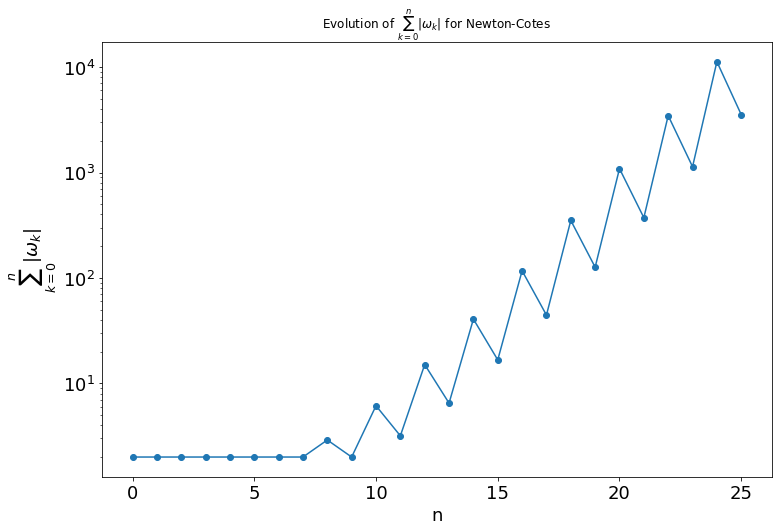

In [13]:
nmax = 25
tab_n = np.arange(0, nmax+1) 
tab_sum = np.zeros(nmax+1) # initialization for the values of the sum for different n

# for n = 0,...,nmax, computation of sum_{k=0}^n |w_k|
for n in tab_n:
    x_n, w_n = coeffs_NewtonCotes(n)
    tab_sum[n] = np.sum(np.abs(w_n))

#plot
fig = plt.figure(figsize=(12, 8))
plt.plot(tab_n, tab_sum, marker="o")
plt.xlabel('n', fontsize = 18)
plt.title('Evolution of $\sum_{k=0}^n |\omega_k|$ for Newton-Cotes')
plt.ylabel('$\sum_{k=0}^n |\omega_k|$', fontsize = 18)
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()

We see that $\sum_{k=0}^n \vert \omega_k \vert$ quickly becomes quite large when $n$ increases, which is made possible by the fact that some of the weights are negative. This does not necessarily mean that with the Newton-Cotes quadrature rule $I^n_{[-1,1]}(f)$ cannot converge to $\int_{-1}^1 f(x) dx$, but we should probably be a bit wary and study some examples.

<div markdown=1, class="DoIt">

Consider again the function $f(x)=\cos\left(\frac{\pi}{2} x\right)$, and study graphically the convergence of $I^n_{[-1,1]}(f)$ to $\int_{-1}^1 f(x) dx$ for Newton-Cotes quadrature. Comment on the obtained results.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


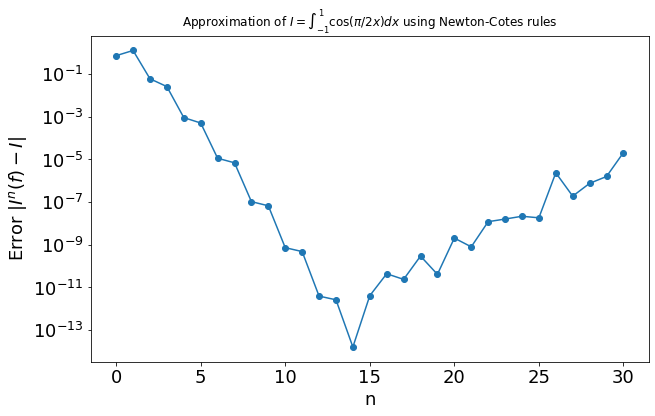

In [14]:
I = 4/pi # exact value of the integral

nmax = 30
tab_n = np.arange(0, nmax+1)
print(tab_n)
tab_In = np.zeros(nmax+1) # initialization for the values of In

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:
    x_n, w_n = coeffs_NewtonCotes(n)
    tab_In[n] = QuadRule(f, x_n, w_n)
    
# computation of the error
tab_err = np.abs(tab_In-I)  # the errors |In-I| for each n 

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_err, marker="o")
plt.xlabel('n', fontsize = 18)
plt.ylabel('Error $| I^n(f) - I |$', fontsize = 18)
plt.title('Approximation of $ I = \int_{-1}^1 \cos(\pi/2 x) dx$ using Newton-Cotes rules')
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1 class='Answer'>

For the function $f(x) = \cos\left(\frac{\pi}{2} x\right)$, we know from the last cycle that even for equidistant nodes the Lagrange interpolation polynomial $P_n(f)$ converges uniformly to $f$ on $[-1,1]$. Therefore, the approximation of the integral obtained using the Newton-Cotes rule is supposed to converge to the exact value. This is indeed what we observe at first, but then rounding errors start to quick in and the error grows again.

<div markdown=1, class="DoIt">

Consider now Runge's function $f_{Runge}(x)=\frac{1}{1+25x^2}$, and study graphically the convergence of $I^n_{[-1,1]}(f_{Runge})$ to $\int_{-1}^1 f_{Runge}(x) dx$ for Newton-Cotes quadrature. Comment on the obtained results. *Hint: to obtain the error, you can use the fact that $\int_{-1}^1 f_{Runge}(x) dx = \frac{2}{5} \arctan (5)$.*

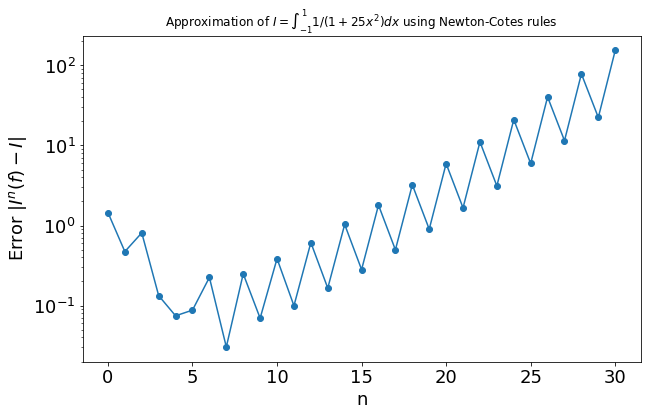

In [15]:
def f_Runge(x):
    return 1/(1+25*x**2)

I = 2/5 * atan(5) # exact value value the integral
nmax = 30
tab_n = np.arange(0, nmax+1)
tab_In = np.zeros(nmax+1) # initialization for the values of In

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:
    x_n, w_n = coeffs_NewtonCotes(n)
    tab_In[n] = QuadRule(f_Runge, x_n, w_n)
    
# computation of the error
tab_err = np.abs(tab_In-I)  # the errors |In-I| for each n 

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_err, marker="o")
plt.xlabel('n', fontsize = 18)
plt.ylabel('Error $| I^n(f) - I |$', fontsize = 18)
plt.title('Approximation of $ I = \int_{-1}^1 1/(1+25x^2) dx$ using Newton-Cotes rules')
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()


<div markdown=1 class='Answer'>

This time the approximation of the integral obtained using the Newton-Cotes rule does not seem to converge at all to the exact value. This is not so surprising since this approximation is obtained by integrating the Lagrange interpolation polynomial $P_n(f)$ for equidistant nodes, and we saw in the last cycle that, for Runge's function and equidistant nodes, $P_n(f)$ does not converge to $f$.

Based on what we have seen in the previous cycle, we can expect quadrature rules based on Lagrange interpolation to behave better if we take Chebyshev nodes instead of equidistant ones. We investigate this option below.

### Clenshaw-Curtis quadrature 正交法

<div markdown=1 class="Def"> 

The **Clenshaw-Curtis quadrature rules** are the quadrature rules based on Lagrange interpolation with Chebyshev nodes. 基于切比雪夫多项式

<div markdown=1 class="Fur"> 

As in the previous chapter, we only work with the Chebyshev points *of the first kind*

$$
\hat{x}_k = \cos\left(\frac{2k + 1}{2n+2}\pi\right), \qquad{} 0 \leq k \leq n,
$$

but he Chebyshev points *of the second kind*

$$
\hat{y}_k = \cos\left(\frac{k}{n}\pi\right), \qquad{} 0 \leq k \leq n,
$$

could also be used.

<div markdown=1 class="Rmk">

We know that, as soon as the function $f$ is slightly regular (say $C^1$), the interpolation polynomial at the Chebyshev nodes converges uniformly on $[-1,1]$ to $f$, which implies that the Clenshaw-Curtis approximation $I^n_{[-1,1]}(f)$ converges to $\int_{-1}^1f(x) dx$. In fact, it can be shown that the Clenshaw-Curtis approximation $I^n_{[-1,1]}(f)$ converges to $\int_{-1}^1f(x) dx$ for any continuous function.

It only remains to find a way to computes the weights of the Clenshaw-Curtis quadrature rule, so that we can easily use it in practice.

<div markdown=1 class="Prop">

Let $V_n$ be the Vandermonde matrix associated with the Chebyshev nodes

$$
V_n=\left(\begin{array}{ccccc} 1 & \hat x_0 & \hat x_0^2 & \ldots & \hat x_0^n \\ 1 & \hat x_1 & \hat x_1^2 & \ldots & \hat x_1^n \\ \vdots & & & &\vdots \\ 1 & \hat x_n & \hat x_n^2 & \ldots & \hat x_n^n \end{array}\right),
$$

define

$$
b_k = \frac{1 + (-1)^k}{k+1}, \qquad{} k=0,\ldots,n,
$$

and $b=\left(b_k\right)_{0\leq k\leq n} \in \mathbb{R}^{n+1}$. Then, the vector $\omega=\left(\omega_k\right)_{0\leq k\leq n} \in \mathbb{R}^{n+1}$ containing the weights of the Clenshaw-Curtis quadrature rule with $n+1$ points satisfies

$$
{}^t V_n\, \omega = b.
$$

>**Proof. $[\star]$** By definition, the Clenshaw-Curtis quadrature of a function $f$ on $[-1,1]$ is given by
>
>$$ 
I^n_{[-1,1]} (f) = \int_{-1}^1  P_n(f)(x) dx = \sum_{k=0}^n f(\hat x_k)\omega_k,
$$
>
>where $P_n(f)$ is the interpolation polynomial of $f$ at the Chebyshev nodes, and $\omega_k$ are the weights we want to determine. In the last chapter, we saw that 
>
>$$
P_n(f)(x) = \sum_{k=0}^n a_k x^k,
$$
>
>where the vector $a=\left(a_k\right)_{0\leq k\leq n}$ satisfies
>
>$$
V_n a = f(\hat x),
$$
>
> with $f(\hat x)=\left(f(\hat x_k)\right)_{0\leq k\leq n}$. Therefore,
>
>\begin{align}
I^n_{[-1,1]} (f) &= \int_{-1}^1  \sum_{k=0}^n a_k x^k dx \\
&= \sum_{k=0}^n a_k \int_{-1}^1   x^k dx \\
&= \sum_{k=0}^n a_k b_k,
\end{align}
>
>which we can also write
>
>$$
I^n_{[-1,1]} (f) = {}^t a\, b.
$$
>
>Then, using that $a = V_n^{-1} f(\hat x)$, we get
>
>\begin{align}
I^n_{[-1,1]} (f) &= {}^t f(\hat x)\, {}^t V_n^{-1}\,b \\
&= \sum_{k=0}^n f(\hat x_k) \left({}^t V_n^{-1}\,b \right)_k
\end{align}
>
>and the weights $\omega=\left(\omega_k\right)_{0\leq k\leq n}$ are indeed given by ${}^t V_n^{-1}\,b$.

<div markdown=1 class='Rmk'>

The above proposition gives us an easy way of computing the weights for Clenshaw-Curtis quadrature.

<div markdown=1 class="Fur"> 
 
There are better ways (i.e. less expensive and more stable ways) of computing these weights, but the required algorithms are slightly more involved, and we will not discuss them in this course.

<div markdown=1 class="DoIt">

Complete the following cell to get a function which computes the nodes and the weights for the Clenshaw-Curtis quadrature of any degree $n$, based on the previous proposition. *Hints: You may want to reuse pieces of code or even full functions from the previous chapter. Check the output of your code for $n=1$ and $n=2$, where you should get approximately $\omega = \left(1,1\right)$ and $\omega = \left(4/9, 10/9, 4/9\right)$ respectively.*

In [16]:
def xhat(n):
    """
    function returning the zeros of Tn
    -----------------------
    Inputs: 
    n : the degree of Tn
    
    Output:
    1D array containing \hat{x}_k for k=0,...,n-1
    """
    if n == 0:
        return np.array([])
    else:
        k = np.arange(0,n)
        x = np.cos((2*k + 1)*np.pi/(2*n))
        return x

def coeffs_ClenshawCurtis(n):
    """
    computation of the nodes and weights for the Clenshaw-Curtis quadrature rule at any order
    ---------------------------------
    Inputs :
    n: degree of the rule (we want n+1 nodes)
    
    Outputs:
    x, w: 1D array containing the nodes and the weights
    """
    x = xhat(n+1) # n+1 Chebyshev nodes
    tab_k = np.arange(0, n+1, dtype='float')
    b = (( 1 + (-1)**tab_k) / (tab_k + 1)) # the vector b=[b0,...bn] defined in the above proposition 
    M = np.vander(x, increasing=True) # Vandermonde Matrix
    w = np.linalg.solve(np.transpose(M), b) # computations of the weights w
    return x, w    

In [17]:
#Sanity check

x_1, w_1 = coeffs_ClenshawCurtis(1)
print(1, x_1, w_1)

x_2, w_2 = coeffs_ClenshawCurtis(2)
print(2, x_2, w_2)

1 [ 0.70710678 -0.70710678] [1. 1.]
2 [ 8.66025404e-01  6.12323400e-17 -8.66025404e-01] [0.44444444 1.11111111 0.44444444]


<div markdown=1 class="DoIt">

Have a look at the weights for Clenshaw-Curtis quadrature for the first few values of $n$. How does it compare to what you obtained for Newton-Cotes quadrature.

In [18]:
np.set_printoptions(precision=1) #to print less digits and have everyhting fitting on one line

for n in np.arange(0, 17):
    x_n, w_n = coeffs_ClenshawCurtis(n)
    print(n, w_n)
    
np.set_printoptions(precision=8) #back to the default number of digits printed

0 [2.]
1 [1. 1.]
2 [0.4 1.1 0.4]
3 [0.3 0.7 0.7 0.3]
4 [0.2 0.5 0.6 0.5 0.2]
5 [0.1 0.4 0.5 0.5 0.4 0.1]
6 [0.1 0.3 0.4 0.5 0.4 0.3 0.1]
7 [0.1 0.2 0.3 0.4 0.4 0.3 0.2 0.1]
8 [0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.1]
9 [0.  0.1 0.2 0.3 0.3 0.3 0.3 0.2 0.1 0. ]
10 [0.  0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0. ]
11 [0.  0.1 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0. ]
12 [0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0. ]
13 [0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0. ]
14 [0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0. ]
15 [0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0. ]
16 [0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0. ]


<div mardown=1 class="Answer">
    
So in this method, all the weights seems stay positive which is great!

Actually, this can be proven (although we will not give the proof in this course).

<div mardown=1 class="Thm">
    
For any integer $n$, the weights $\omega_k$ ($k=0,..,n$) of the Clenshaw-Curtis quadrature rule of degree $n$ are all positive.

<div markdown=1, class="DoIt">

For Clenshaw-Curtis quadrature, study graphically the behavior of $\sum_{k=0}^n \vert \omega_k \vert$ when $n$ increases.

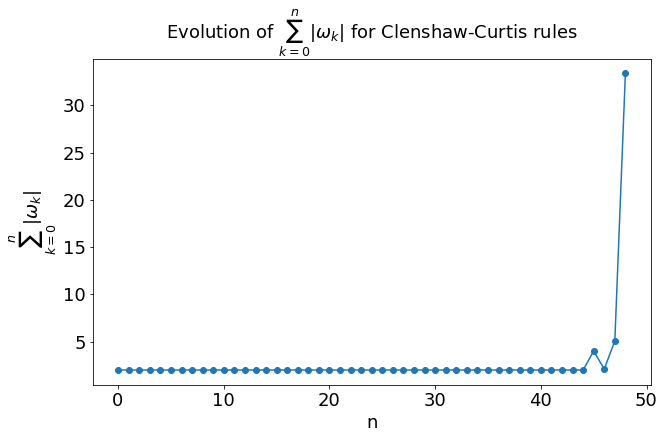

In [19]:
nmax = 48
tab_n = np.arange(0, nmax+1) 
tab_sum = np.zeros(nmax+1) # initialization for the values of the sum for different n

# for n = 0,...,nmax, computation of sum_{k=0}^n |w_k|
for n in tab_n:
    x_n, w_n = coeffs_ClenshawCurtis(n)
    tab_sum[n] = np.sum(np.abs(w_n))   
    
#plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_sum, marker="o")
plt.xlabel('n', fontsize = 18)
plt.title('Evolution of $\sum_{k=0}^n |\omega_k|$ for Clenshaw-Curtis rules', fontsize = 18)  
plt.ylabel('$\sum_{k=0}^n |\omega_k|$', fontsize = 18)
plt.tick_params(labelsize = 18)
plt.show()

<div mardown=1 class="Rmk">
    
After a while ($n>43$), $\sum_{k=0}^n \vert \omega_k \vert$ also becomes significantly larger than $2$. Since in theory we should always have $\sum_{k=0}^n \vert \omega_k \vert = 2$, this must be due to rounding errors, and could be mitigated by using a better algorithm to compute the weights.

<div markdown=1, class="DoIt">

Consider again the function $f(x)=\cos\left(\frac{\pi}{2} x\right)$, and study graphically the convergence of $I^n_{[-1,1]}(f)$ to $\int_{-1}^1 f(x) dx$, this time for Clenshaw-Curtis quadrature. Comment on the obtained results.

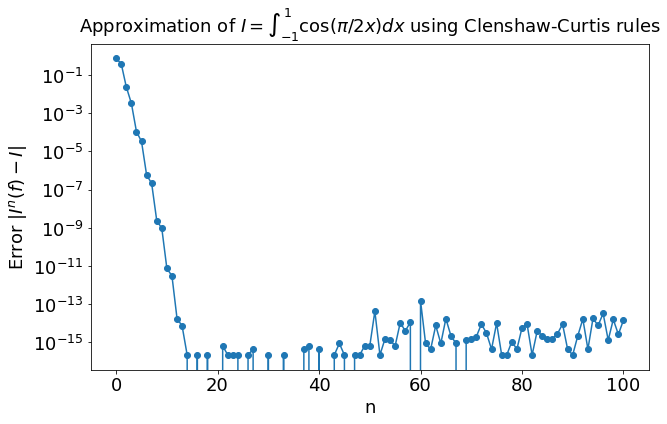

In [20]:
I = 4/pi # exact value of the integral

nmax = 100
tab_n = np.arange(0, nmax+1)
tab_In = np.zeros(nmax+1) # initialization for the values of In

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:
    x_n, w_n = coeffs_ClenshawCurtis(n)
    tab_In[n] = QuadRule(f, x_n, w_n)
    
# computation of the error
tab_err = np.abs(tab_In - I)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_err, marker="o")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| I^n(f) - I |$', fontsize = 18)
plt.title('Approximation of $ I = \int_{-1}^1 \cos(\pi/2 x) dx$ using Clenshaw-Curtis rules', fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1 class='Answer'>

We observe the convergence of the approximation obtained using the Clenshaw-Curtis rule to the exact value of the integral, as expected. Of course the error saturates at some point due to rounding errors, but contrarily to what happened with the Newton-Cotes rule, the error does not dramatically increase when the rounding errors quick in.

<div markdown=1, class="DoIt">

Consider now Runge's function $f_{Runge}(x)=\frac{1}{1+25x^2}$, and study graphically the convergence of $I^n_{[-1,1]}(f_{Runge})$ to $\int_{-1}^1 f_{Runge}(x) dx$ for Clenshaw-Curtis quadrature. Comment on the obtained results. *Hint: to obtain the error, you can use the fact that $\int_{-1}^1 f_{Runge}(x) dx = \frac{2}{5} \arctan (5)$.*

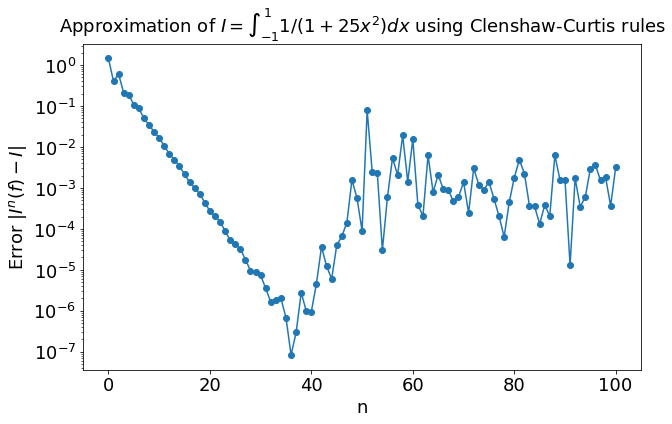

In [21]:
def f_Runge(x):
    return 1/(1+25*x**2)

nmax = 100
I = 2/5 * atan(5) # exact value value the integral
tab_n = np.arange(0, nmax+1)
tab_In = np.zeros(nmax+1)

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:
    x_n, w_n = coeffs_ClenshawCurtis(n)
    tab_In[n] = QuadRule(f_Runge, x_n, w_n)
    
# computation of the error
tab_err = np.abs(tab_In - I)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_err, marker="o")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| I^n(f) - I |$', fontsize = 18)
plt.title('Approximation of $ I = \int_{-1}^1 1/(1+25x^2) dx$ using Clenshaw-Curtis rules', fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()


<div markdown=1 class='Answer'>

We again observe convergence at first, which was not the case for Newton-Cotes quadrature on this example. This time the rounding errors affect the result more strongly when $n$ increases (this could be mitigated by using a better algorithm for computing the weights).

### Gaussian quadrature 高斯求积

<img src="figures/Gauss.jpg" alt="Gauss" style="width: 170px;" />

>**Carl Friedrich Gauss (1777 - 1855).**
> Carl Freidrich Gauss is a German mathematician, astronomer and physicist. He made significant contributions to these three fields, including algebra, analysis, optics, mechanics, magnetic fields, matrix theory, statistics... He had a great influence in many fields of science and is sometime referred to as the *Princeps mathematicorum*. Concerning numerical integration, he developed a $(n+1)$-point quadrature method yielding an exact result for polynomials of degree $2n+1$.

At the beginning of this chapter, we obtained the following estimate for a quadrature rule of degree of accuracy at least $n_a$

$$
\left\vert \int_{-1}^{1} f(x)dx - I^n_{[-1,1]}(f)\,\right\vert \leq \frac{2+\sum_{k=0}^n |\omega_k| }{(n_a+1)!}\sup_{x\in [-1,1]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert,
$$

which suggests that it may be a good idea to find quadrature rules having the highest possible degree of accuracy.

<div markdown=1 class="DoIt">

Check numerically the degree of accuracy of Clenshaw-Curtis quadrature for the first few values of $n$, using the function `test_exactness`.

In [22]:
for n in np.arange(0,5):
    print("n = %s" %n)
    x, w = coeffs_ClenshawCurtis(n)
    test_exactness(x, w, n+2)
    print("\n")

n = 0
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 0.0000


n = 1
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = -0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 1.0000
int[-1,1] x^3 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000


n = 2
int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = -0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 0.6667
int[-1,1] x^3 : exact value (4 digits) = 0.0000, quadrature (4 digits) = -0.0000
int[-1,1] x^4 : exact value (4 digits) = 0.4000, quadrature (4 digits) = 0.5000


n = 3
int[-1,

While Clenshaw-Curtis quadrature already performs much better than Newton-Cotes quadrature, both have the same degree of accuracy, namely $n_a=n+1$ when $n$ is even, and $n_a=n$ when $n$ is odd, $n$ being the degree of the quadrature rule (i.e. when we use $n+1$ nodes).

However, when constructing a quadrature rule of degree $n$:

$$
I^n_{[-1,1]}(f) = \sum_{k=0}^n f(x_k) \omega_k,
$$

we have $2n+2$ degrees of freedom, or if you prefer $2n+2$ parameters than we can choose, namely the $n+1$ nodes $x_0,\ldots,x_n$ and the $n+1$ weights $\omega_0,\ldots,\omega_n$. This suggests that we could try to satisfy $2n+2$ constraints, and for instance try to have

$$
I^n_{[-1,1]}(X^j) = \int_{-1}^1 x^j dx \qquad{} j=0,\ldots,2n+1,
$$

which would give us a rule having a degree of accuracy of at least $2n+1$.

- **Case $n=1$. We want to obtain a quadrature rule with $\,\,n_a=2n+1=3$.**

In that case, we have to find $x_0$, $x_1$, $\omega_0$, $\omega_1$ such that 

$$
\int_{-1}^1 P(x) dx = \omega_0 P(x_0) + \omega_1 P(x_1) \quad{} \text{for}\quad{} P(x)=1,\, P(x)=x,\, P(x)=x^2 \text{ and } P(x)=x^3.
$$

This provides the following 4 equations with 4 unknowns to be solved for $(x_0,x_1,\omega_0,\omega_1)$:

\begin{align}
\left\{
\begin{aligned}
2 & = \omega_0 + \omega_1 \\
0 & = \omega_0\,x_0 + \omega_1\,x_1 \\
\frac{2}{3} & = \omega_0\,x_0^2 + \omega_1\,x_1^2 \\
0 & = \omega_0\,x_0^3 + \omega_1\,x_1^3 
\end{aligned}
\right.
\end{align}

<div markdown=1 class="DoIt">

Find a solution to the above system. *Hint: you may look for a solution with symmetric nodes, that is such that $x_0 = - x_1$ and $\omega_0 = \omega_1$.*

<div markdown=1 class="Answer">

Using the hint, the first equation yields $2=2\omega_0$, i.e. $\omega_0=1$. The second equation is automatically satisfied with the symmetry assumptions. The third equation yields $\frac{2}{3} = 2 x_0^2$, i.e. $x_0 = \sqrt{\frac{1}{3}}$. The fourth equation is also automatically satisfied with the symmetry assumptions. 


<img src="./figures/Gauss1_Elem.png" alt="Gauss1 Elem" style="height: 300px;"/>

We finally end up with the following rule:

\begin{array}{c|cc}
x_k & -\frac{1}{\sqrt 3} & \frac{1}{\sqrt 3} \\ \hline
\omega_k& 1 & 1
\end{array}

<div markdown=1 class="DoIt">

Create the arrays $x$ and $\omega$ corresponding to this rule, and check numerically the degree of accuracy.

In [23]:
# Gaussian quadrature of degree 1
x_G1 = np.array([-1/math.sqrt(3), 1/math.sqrt(3)]) # nodes
w_G1 = np.array([-1, 1]) # weights

test_exactness(x_G1, w_G1, 4)

int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 1.1547
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 0.0000
int[-1,1] x^3 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.3849
int[-1,1] x^4 : exact value (4 digits) = 0.4000, quadrature (4 digits) = 0.0000


- **Case $n=2$. We want to obtain a quadrature rule with $\,\,n_a=2n+1=5$.**

In that case, we have to find $x_0$, $x_1$, $x_2$, $\omega_0$, $\omega_1$, $\omega_2$ such that 

$$
\int_{-1}^1 P(x) dx = \omega_0 P(x_0) + \omega_1 P(x_1) + \omega_2 P(x_2).
$$

$$
\text{for}\quad{} P(x)=1,\, P(x)=x,\, P(x)=x^2 \, P(x)=x^3 \, P(x)=x^4 \text{ and } P(x)=x^5.
$$

As before, we can look for a symmetric nodes, i.e. such that

$$
x_0 = - x_2,\quad{} x_1 = 0,\quad{} \text{and}\quad \omega_0 = \omega_2.
$$

After some computations (feel free to try and do them as an exercise if you want), we end up with the following coefficients:

\begin{array}{c|cc}
x_k & -\sqrt{\frac{3}{5}} & 0 & \sqrt{\frac{3}{5}} \\ \hline
\omega_k & \frac{5}{9} & \frac{8}{9} & \frac{5}{9}
\end{array}

<img src="./figures/Gauss2_Elem.png" alt="Gauss2 Elem" style="height: 300px;"/>

<div markdown=1 class="DoIt">

Create the arrays $x$ and $\omega$ corresponding to this rule, and check numerically the degree of accuracy.

In [24]:
# Gaussian quadrature of degree 2
x_G2 = np.array([-math.sqrt(3/5), 0, math.sqrt(3/5)]) # nodes
w_G2 = np.array([5/9, 8/9, 5/9]) # weights

test_exactness(x_G2, w_G2, 6)

int[-1,1] x^0 : exact value (4 digits) = 2.0000, quadrature (4 digits) = 2.0000
int[-1,1] x^1 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^2 : exact value (4 digits) = 0.6667, quadrature (4 digits) = 0.6667
int[-1,1] x^3 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^4 : exact value (4 digits) = 0.4000, quadrature (4 digits) = 0.4000
int[-1,1] x^5 : exact value (4 digits) = 0.0000, quadrature (4 digits) = 0.0000
int[-1,1] x^6 : exact value (4 digits) = 0.2857, quadrature (4 digits) = 0.2400


<div markdown=1, class="DoIt">

As a first test for Gaussian quadrature rules, consider again the function $f(x)=\cos\left(\frac{\pi}{2} x\right)$, and its integral on $[-1,1]$. For a given degree $n=2$ (i.e. with 3 nodes), compare the approximate results obtained with Newton-Cotes quadrature, Clenshaw-Curtis quadrature and Gaussian quadrature.

In [25]:
def f(x):
    return  np.cos(pi/2*x)

I = 4/pi # exact value of the integral of f from -1 to 1

n = 2
x_NC, w_NC = coeffs_NewtonCotes(n) # coefficients for the Newton-Cotes quadrature 
x_CC, w_CC = coeffs_ClenshawCurtis(n) # coefficients for the Clenshaw-Curtis quadrature

I_NC = QuadRule(f, x_NC, w_NC) # approximate integral with Newton-Cotes quadrature
I_CC = QuadRule(f, x_CC, w_CC) # approximate integral with Clenshaw-Curtis quadrature
I_G = QuadRule(f, x_G2, w_G2) # approximate integral with Gaussian quadrature


print("Exact value of the integral : %.5f" % I)
print("Approximation of the integral using Newton-Cotes quadrature rule : %.5f" % I_NC)
print("Approximation of the integral using Clenshaw-Curtis quadrature rule : %.5f" % I_CC)
print("Approximation of the integral using Gaussian quadrature rule : %.5f" % I_G)

Exact value of the integral : 1.27324
Approximation of the integral using Newton-Cotes quadrature rule : 1.33333
Approximation of the integral using Clenshaw-Curtis quadrature rule : 1.29680
Approximation of the integral using Gaussian quadrature rule : 1.27412


In all three cases we use the same number of nodes (and therefore we need the same number of evaluations of $f$), but Gaussian quadrature gives a more precise result, which is what we were hopping for when trying to obtain a rule with a higher degree of accuracy. 

- **General case**

Let us now consider the general case. The integer $n$ being given, one wants to find nodes $x_0,\ldots,x_n$ and weights $\omega_0,\ldots,\omega_n$ such that the associated quadrature rule 

$$
I^n_{[-1,1]}(f) = \sum_{k=0}^n f(x_k) \omega_k,
$$

has a degree of accuracy of at least $n_a=2n+1$.

Suppose for the moment that such coefficients exist, and consider $\Pi(x)=(x-x_0)(x-x_1)\ldots(x-x_n)$ which is a polynomial of degree $n+1$. Then, for any polynomial $P$ of degree lower or equal to $n$ we have that $P\Pi$ is a polynomial of degree lower or equal to $n_a$. As a consequence we have

$$
\int_{-1}^1 P(x)\Pi(x) dx = I^n_{[-1,1]} (P\,\Pi) = \sum_{k=0}^n \omega_k P(x_k)\Pi(x_k) = 0.
$$

Therefore, for any polynomial $P$ of degree $n$ or less, we have

$$
\int_{-1}^1 P(x)\Pi(x) dx =0.
$$

This property encourages us to consider so-called **orthogonal polynomials**.

<div  markdown=1 class="Prop"> 

**Legendre orthogonal polynomials. 勒让德正交多项式** There exists a unique family of polynomials $\left(Q_n\right)_{n\geq 0}$ verifying

- $Q_n$ is of degree $n$,
- $\displaystyle \int_{-1}^1 P(x) Q_n(x) dx = 0$ for any polynomial $P$ of degree at most $n-1$,
- $Q_n(1)=1$.

These polynomials are called the Legendre polynomials. It can be proven that they have $n$ distinct roots in $(-1,1)$.

Notice that the polynomial $\Pi$ defined just above is of degree $n+1$ and satisfies $\displaystyle \int_{-1}^1 P(x) \Pi(x) dx = 0$ for any polynomial $P$ of degree at most $n$. Therefore, one could try taking $\Pi = Q_{n+1}$, that is using the roots of the $n+1$-th Legendre polynomial $Q_{n+1}$ as the quadrature nodes.

<div markdown=1 class="Def"> 

The **Gaussian (or Gauss-Legendre) quadrature rules** are the quadrature rules based on Lagrange interpolation for which the $n+1$ nodes are the roots of the $n+1$-th Legendre polynomial $Q_{n+1}$.

We prove below that this choice indeed leads to a quadrature rule having a degree of accuracy $n_a=2n+1$.

<div  markdown=1 class="Thm"> 

The Gaussian (or Gauss-Legendre) quadrature rule of degree $n$ (i.e. with $n+1$ nodes) has a degree of accuracy $n_a=2n+1$.

>**Proof. $[\star]$** We first have to prove that $Q_{n+1}$ has $n+1$ distinct roots in $(-1,1)$. Let us assume by contradiction that $Q_{n+1}$ has $d+1<n+1$ distinct roots $x_0,\ldots,x_d$ in $(-1,1)$. This means we can write
>
>$$
Q_{n+1}(x) = R(x) \prod_{k=0}^d (x-x_k)^{\alpha_k},
$$
>
>where $R$ is a polynomial having no roots in $(-1,1)$, and $\alpha_k \geq 1$, $k=0,\ldots,d$. We are going to reach a contradiction by using the fact that
>
>$$
\int_{-1}^1 P(x) Q_{n+1} dx = 0,
$$
>
>for all polynomials of degree at most $n$. Indeed, let us consider
>
>$$
P(x) = \prod_{k=0}^d (x-x_k)^{\beta_k}
$$
>
>where
>
>$$
\beta_k = 
\left\{
\begin{aligned}
&1 \qquad{} \text{if }\alpha_k \text{ is odd,} \\
&0 \qquad{} \text{if }\alpha_k \text{ is even.}
\end{aligned}
\right.
$$
>
> This polynomial is of degree at most $n$ because we assumed $d<n$, and therefore
>
>\begin{align}
 0 &= \int_{-1}^1 \prod_{k=0}^d (x-x_k)^{\beta_k} Q_{n+1}(x) dx  \\
 &= \int_{-1}^1 \prod_{k=0}^d (x-x_k)^{\alpha_k+\beta_k} R(x) dx.
\end{align}
>
>However, $\prod_{k=0}^d (x-x_k)^{\alpha_k+\beta_k}$ is nonnegative ($\alpha_k+\beta_k$ is even for all $k$) and $R$ has a constant sign on $(-1,1)$ (it does not have any zero in $(-1,1)$), therefore the integral cannot be equal to $0$, contradiction.
>
>Now that we have shown that $Q_{n+1}$ has $n+1$ distinct roots in $(-1,1)$, let us prove that the quadrature rule based on Lagrangian interpolation at these nodes has a degree of accuracy of at least $2n+1$. Let $P$ be a polynomial of degree lower or equal to $2n+1$, and let us consider the euclidean division of $P$ by the $n+1$-th Legendre polynomial $Q_{n+1}$:
>
>$$
P = A Q_{n+1}  + B \quad{}\text{ with }\quad{} B \text{ of degree at most } n.
$$
>
>From the degrees of $Q_{n+1}$ and $P$ we have that the degree of $A$ is lower or equal to $n$, and therefore
>
>$$
\int_{-1}^1 P(x)dx = \int_{-1}^1  A(x)Q_{n+1}(x) dx + \int_{-1}^1 B(x)dx = \int_{-1}^1 B(x)dx.
$$
>
>Moreover, since the quadrature points $(x_k)$ are the roots of $Q_{n+1}$, we have 
>
>$$
I^n_{[-1,1]}(P) = \sum_{k=0}^n P(x_k) \omega_k = \sum_{k=0}^n \left(A(x_k) Q_{n+1}(x_k)  + B(x_k) \right) \omega_k = \sum_{k=0}^n B(x_k) \omega_k = I^n_{[-1,1]}(B).
$$
>
>Finally, since the quadrature rule is based on Lagrange interpolation, it is exact for polynomials of degree $n$, and therefore $I^n_{[-1,1]}(B) = \int_{-1}^1 B(x)dx$. Putting everything together, we get
>
>$$
\int_{-1}^1 P(x)dx = \int_{-1}^1 B(x)dx = I_{[-1,1]} (B) = I_{[-1,1]} (P).
$$
>
>and the quadrature rule has indeed a degree of accuracy of at least $2n+1$.
>
> It remains to prove that the degree of accuracy is exactly equal to $2n+1$. To do so, we consider the polynomial $P(x)=(x-x_0)^2(x-x_1)^2\ldots(x-x_n)^2$ of degree $2n+2$, for which we have
>
>$$
I^n_{[-1,1]} (P) = \sum_{k=0}^n \omega_k P(x_k) = 0 \neq \int_{-1}^1 P(x) dx,
$$ 
>
>because $P$ is nonnegative.

<div markdown=1 class="Rmk">

- As for the Clenshaw-Curtis rule, it can be shown that the Gaussian quadrature $I^n_{[-1,1]}(f)$ converges to $\int_{-1}^1f(x) dx$ for any continuous function.
- This Gaussian quadrature rule is also called Gauss-Legendre quadrature rule.

The nodes and weights for the Gauss-Legendre quadrature can be obtained using the funciong `roots_legendre` from scipy.special.

In [26]:
def coeffs_GaussLegendre(n):
    """
    computation of the nodes and weights for the Gaussian (or Gauss-Legendre) quadrature rule at any order
    ---------------------------------
    Inputs :
    n: degree of the rule (we want n+1 nodes)
    
    Outputs:
    x, w: 1D array containing the nodes and the weights
    """
    return roots_legendre(n+1)

In [27]:
#Sanity check

x_1, w_1 = coeffs_GaussLegendre(1)
print(1, x_1, w_1)

x_2, w_2 = coeffs_GaussLegendre(2)
print(2, x_2, w_2)

1 [-0.57735027  0.57735027] [1. 1.]
2 [-0.77459667  0.          0.77459667] [0.55555556 0.88888889 0.55555556]


<div mardown=1 class="Thm">
    
For the Gauss-Legendre quadrature, all the weights $\omega_k$ are positive for all $n$.

<div markdown=1, class="DoIt">

For the Gauss-Legendre quadrature, study graphically the behavior of $\sum_{k=0}^n \vert \omega_k \vert$ when $n$ increases.

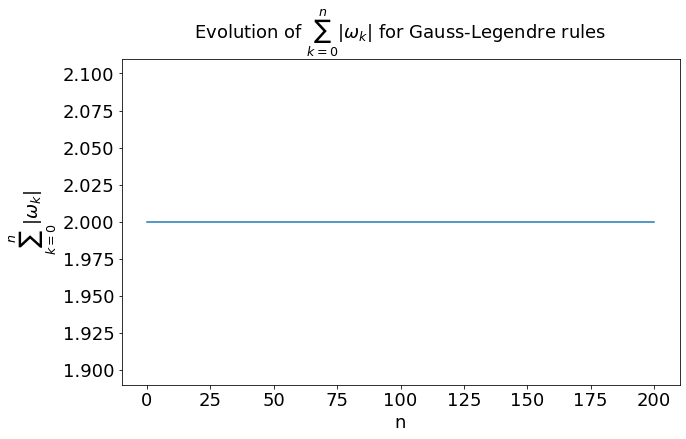

In [28]:
nmax = 200
tab_n = np.arange(0, nmax+1) 
tab_sum = np.zeros(nmax+1) # initialization for the values of the sum for different n

# for n = 0,...,nmax, computation of sum_{k=0}^n |w_k|
for n in tab_n:
    x_n, w_n = coeffs_GaussLegendre(n)
    tab_sum[n] = np.sum(np.abs(w_n))

#plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_sum, marker="")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('$\sum_{k=0}^n |\omega_k|$', fontsize = 18)
plt.title('Evolution of $\sum_{k=0}^n |\omega_k|$ for Gauss-Legendre rules', fontsize = 18) 
plt.tick_params(labelsize = 18)
plt.show()

<div mardown=1 class="Rmk">
    
As expected, since all the weights $\omega_k$ are supposed to be positive, $\sum_{k=0}^n \vert \omega_k \vert$ stays equal to $2$ for all $n$. Apparently, the algorithm used by scipy for computing these weights is more stable than the one we used for Clenshaw-Curtis quadrature, because we do not seem to have problems with rounding errors.

<div markdown=1, class="DoIt">

Consider again the function $f(x)=\cos\left(\frac{\pi}{2} x\right)$, and study graphically the convergence of $I^n_{[-1,1]}(f)$ to $\int_{-1}^1 f(x) dx$, both for Clenshaw-Curtis quadrature and for Gauss-Legendre quadrature.

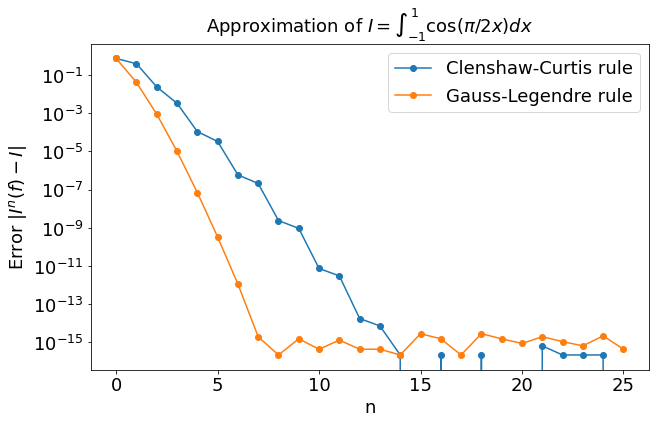

In [29]:
I = 4/pi # exact value

nmax = 25
tab_n = np.arange(0, nmax+1)
tab_InCC = np.zeros(nmax+1)
tab_InGL = np.zeros(nmax+1)

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:
    x_nCC, w_nCC = coeffs_ClenshawCurtis(n)
    tab_InCC[n] = QuadRule(f, x_nCC, w_nCC)
    x_nGL, w_nGL = coeffs_GaussLegendre(n)
    tab_InGL[n] = QuadRule(f, x_nGL, w_nGL)
    
# computation of the error
tab_errCC = np.abs(tab_InCC-I)
tab_errGL = np.abs(tab_InGL-I)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_errCC, marker="o", label="Clenshaw-Curtis rule")
plt.plot(tab_n, tab_errGL, marker="o", label="Gauss-Legendre rule")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| I^n(f) - I |$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $ I = \int_{-1}^1 \cos(\pi/2 x) dx$', fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1 class='Answer'>

For both quadrature rules, we observe the convergence to the exact value of the integral, as expected,  However we can see that the convergence of Gauss-Legendre seems faster than Clenshaw-Curtis rule

<div markdown=1, class="DoIt">

Repeat this comparison, this time with the function $f_{Runge}(x)=\frac{1}{1+25x^2}$.

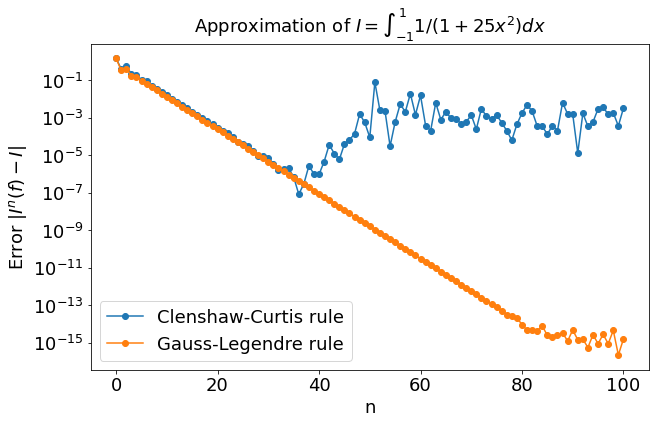

In [30]:
def f_Runge(x):
    return 1/(1+25*x**2)

I = 2/5 * atan(5) # exact value

nmax = 100
tab_n = np.arange(0, nmax+1)
tab_InCC = np.zeros(nmax+1)
tab_InGL = np.zeros(nmax+1)

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:
    x_nCC, w_nCC = coeffs_ClenshawCurtis(n)
    tab_InCC[n] = QuadRule(f_Runge, x_nCC, w_nCC)
    x_nGL, w_nGL = coeffs_GaussLegendre(n)
    tab_InGL[n] = QuadRule(f_Runge, x_nGL, w_nGL)
    
# computation of the error
tab_errCC = np.abs(tab_InCC-I)
tab_errGL = np.abs(tab_InGL-I)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_errCC, marker="o", label="Clenshaw-Curtis rule")
plt.plot(tab_n, tab_errGL, marker="o", label="Gauss-Legendre rule")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| I^n(f) - I |$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title("Approximation of $ I = \int^{1}_{-1} 1/(1+25x^2)dx $", fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()


<div markdown=1 class='Answer'>

On this example we don't see the significant difference between the two mehod except the Clenshaw-Curtis rule have a little value differences of the convergence when n is around 30 - 40. However, when we increase n to around 100, we can significantly find that the Gauss-Legendre rule converge much better than Clenshaw-Curtis rule


<div markdown=1, class='Rmk'>

We re-emphasize that the fact that rouding errors seems more impactful for Clenshaw-Curtis quadrature has nothing to do with the quadrature rule itself, only with the algorithms that are used to compute the weights.

The fact that both quadrature rules have rather similar properties is not a coincidence: The nodes are actually not that different, and distributed in a similar fashion, as can be seen in the next picture.

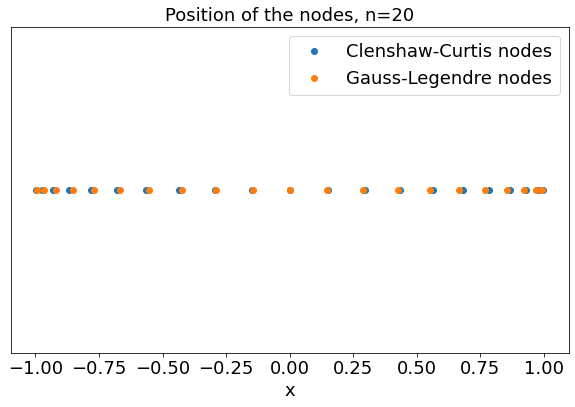

In [31]:
n = 20
x_CC, w_CC = coeffs_ClenshawCurtis(n)
x_GL, w_GL = coeffs_GaussLegendre(n)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(x_CC, 0*x_CC, marker="o", linestyle="", label="Clenshaw-Curtis nodes")
plt.plot(x_GL, 0*x_GL, marker="o", linestyle="", label="Gauss-Legendre nodes")
plt.xlabel('x', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Position of the nodes, n=%s' %n, fontsize = 18) 
plt.tick_params(labelsize = 18)
plt.yticks([])
plt.show()


**Conclusions**

- <mark>While Newton-Cotes quadrature rules do not behave well when $n$ becomes too large, Clenshaw-Curtis and Gauss-Legendre rules both have very good theoretical properties: they converge for any continuous function, and the smoother the function the faster the convergence.</mark> However, even for Clenshaw-Curtis and Gauss-Legendre rules, one has to be mindful about how the weights are computed for large $n$ (there exist good algorithms to compute these weights in a stable and efficient manner, but this goes beyond the scope of this course).

- Form the viewpoint of the degree of accuracy, Gauss-Legendre rules are superior to Clenshaw-Curtis rules, but when we look at the error for $n$ large there is not always a big difference between the two.

<a id="CompQuad"></a>
## Composite integration 复合积分方法

If we want to avoid using a quadrature rule with a very large $n$, we can use instead a **piecewise** approach, based on a subdivision of the interval in $m$ smaller subintervals, and elementary quadrature rules of lower degree $n$ on each subinterval.  We describe and analyze the behavior of such a piecewise approach in this section.

Let $(x_k)_{k=0\ldots m}$ be $m+1$ distinct given points in $[a,b]$, such that $a=x_0<x_1<\ldots<x_m=b$. We consider the corresponding subdivision of the interval:

$$
[a,b] = \bigcup_{k=0}^{m-1} [x_k,x_{k+1}].
$$

The set of points $(x_k)_{i=0\ldots m}$ is said to be a **mesh of the interval $[a,b]$** and we define the **mesh size** as:

$$h = \max_{k=0\ldots m-1}{\lvert x_{k+1} - x_k \rvert}.$$

This parameter $h$ is the one we are going to change to adapt the quality of the approximation: hopefully, when $h$ goes to $0$ we get closer and closer to the exact integral.

<div markdown = 1 class = "Def"> 

Consider an interval $[a,b]$, a set of $m+1$ mesh points $(x_k)_{0\leq k\leq m}$ such that $a = x_0 < x_1 < \ldots < x_m = b$, and an integer $n$. A **composite quadrature rule** of degree $n$ associated to the mesh $(x_k)_{0\leq k\leq m}$ is an approximation of $\int_a^b$ of the following form 

$$
\int_a^b f(x)dx = \sum_{k=0}^{m-1} \int_{x_k}^{x_{k+1}} f(x)dx  \approx \sum_{k=0}^{m-1} I^n_{[x_k,x_{k+1}]}(f),
$$

where $I^n_{[x_k,x_{k+1}]}$ is an elementary quadrature rule of degree $n$ on $[x_k,x_{k+1}]$.

We denote by $E_m(f)$ the error

$$
E_m(f) = \left\vert \int_a^b f(x)dx - \sum_{k=0}^{m-1} I^n_{[x_k,x_{k+1}]}(f) \right\vert ,
$$

associated to such a composite quadrature rule (the error also depends on $n$, on $[a,b]$, and on the mesh, but our focus will be on the behavior of the error when $m$ goes to infinity).

<div markdown=1, class='Rmk'>

- The elementary quadrature rule $I^n_{[x_k,x_{k+1}]}$ can be any of the quadrature rules of degree $n$ that we have seen up to now.

- In principle, one could use a different quadrature rule on each subinterval $[x_k,x_{k+1}]$ (and even change the degree $n$ on each subinterval), but to keep things simple we only consider here composite quadrature rules with the same elementary rule on all subintervals.

- Also to keep things simple, in practice we are only going to use uniform meshes, meaning that the $x_k$ are given by
$$
x_k = a + k\frac{b-a}{m}.
$$
In that situation, each subinterval has length $h=\frac{b-a}{m}$, and making $h$ go to zero is equivalent to making $m$ go to infinity.

- **Composite left rectangle method**

For $n=0$, if we use the left rectangle elementary rule on each subinterval we obtain:

$$
\int_a^b f(x)dx  \approx \sum_{k=0}^{m-1} I^0_{[x_k,x_{k+1}]}(f) = \sum_{k=0}^{m-1} (x_{k+1}-x_k)\,f(x_k).
$$

If we use a uniform mesh, we simply get the following formula for the composite left rectangle method:

$$
\int_a^b f(x)dx  \approx \frac{b-a}{m}\sum_{k=0}^{m-1} f(x_k).
$$

<img src="./figures/RectL_Comp.png" alt="RectL Comp" style="height: 300px;"/>

- **Composite midpoint method**



- **Composite trapezoidal method**

For $n=1$, the composite quadrature based on the elementary trapezoidal rule gives:

$$
\int_a^b f(x)dx  \approx \sum_{k=0}^{m-1} I^0_{[x_k,x_{k+1}]}(f) = \sum_{k=0}^{m-1} \frac{x_{k+1}-x_k}{2}\,(f(x_k)+f(x_{k+1})).
$$

If we use a uniform mesh, we simply get the following formula for the composite trapezoidal method:

$$
\int_a^b f(x)dx  \approx \frac{b-a}{m}\sum_{k=0}^{m-1} \frac{f(x_k)+f_(x_{k+1})}{2} = \frac{b-a}{m}\left(\frac{f(x_0)+f(x_{m})}{2} + \sum_{k=1}^{m-1} f(x_k) \right) .
$$

<img src="./figures/Trap_Comp.png" alt="Trap Comp" style="height: 300px;"/>

### First tests

<div markdown=1 class="DoIt">

Complete the following cell to get a function `QuadRule_composite` which evaluates such a piecewise approximation of the integral. *Hints: you may use the function `QuadRule` on each subinterval, and the fact that, given some $nodes$ and $weights$ for an elementary quadrature rule on $[-1,1]$, the corresponding nodes and weights on any interval $[a,b]$ are given by $a + (nodes+1)(b-a)/2$ and $weights(b-a)/2$ respectively.*

In [32]:
def QuadRule_composite(f, mesh, nodes_elem, weights_elem):
    """
    Approximate integral using a composite quadrature rule
    -----------------------------------------
    Inputs :
    f: function to be integrated
    mesh: the mesh points [x_0,...,x_m] defining the subintervals
    nodes_elem, weights_elem: the coefficients of the elementary quadrature rule (on [-1,1])
    
    Output
    the value of the composite quadrature rule applied to f
    """
    m = mesh.size - 1 # number of subintervals
    I_comp = 0
    for k in np.arange(0,m):
        xk = mesh[k] # getting x_k
        xkp1 = mesh[k+1] # getting x_{k+1}
        nodes_rescaled = xk+(nodes_elem+1)*(xkp1-xk)/2 # nodes of the elementary rule rescaled for the interval [x_k,x_{k+1}]
        weights_rescaled = weights_elem*(xkp1-xk)/2 # weights of the elementary rule rescaled for the interval [x_k,x_{k+1}]
        I_comp = I_comp + QuadRule(f, nodes_rescaled, weights_rescaled) # elementary quadrature on [x_k,x_{k+1}]
    return I_comp

<div markdown=1 class="DoIt">

Consider again the function $f(x)=\cos\left(\frac{\pi}{2} x\right)$, and its integral between $-1$ and $1$. Using the function `QuadRule_composite`, approximate this integral using a composite quadrature rule with a uniform mesh and $n=1$ for the elementary rule. Study the behavior of the error when $m$ increase, and compare what happens when the elementary rule is a Newton-Cotes rule, a Clenshaw-Curtis rule, or a Gauss-Legendre rule (always of degree $n=1$ for the moment).

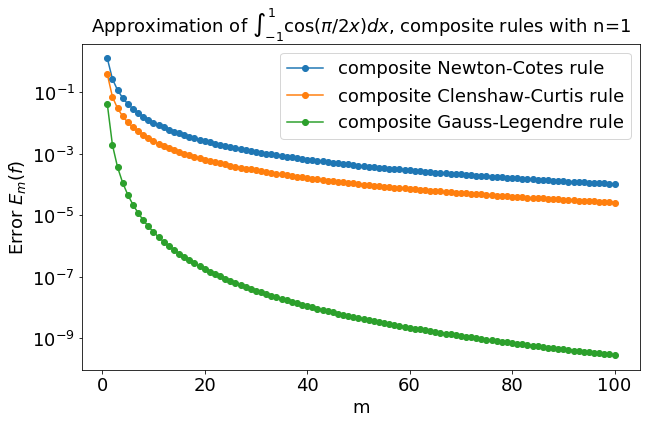

In [33]:
def f(x):
    return  np.cos(pi/2*x)

a = -1
b = 1
I = 4/pi # exact value of the integral of f from -1 to 1

# coefficients on [-1,1] for each elementary rule
n = 1
nodes_elem_NC, weights_elem_NC = coeffs_NewtonCotes(n) 
nodes_elem_CC, weights_elem_CC = coeffs_ClenshawCurtis(n)
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m_max = 100
tab_m = np.arange(1, m_max+1)
# Initialization
tab_IcompNC = np.zeros(m_max)
tab_IcompCC = np.zeros(m_max)
tab_IcompGL = np.zeros(m_max)

# computation of the approximated value of the integral for m = 1,...,m_max
for m in tab_m:
    mesh = np.linspace(a, b, m+1)
    tab_IcompNC[m-1] = QuadRule_composite(f, mesh, nodes_elem_NC, weights_elem_NC)
    tab_IcompCC[m-1] = QuadRule_composite(f, mesh, nodes_elem_CC, weights_elem_CC)
    tab_IcompGL[m-1] = QuadRule_composite(f, mesh, nodes_elem_GL, weights_elem_GL)
    
# computation of the error
tab_errNC = np.abs(tab_IcompNC-I)
tab_errCC = np.abs(tab_IcompCC-I)
tab_errGL = np.abs(tab_IcompGL-I)

# plot
tab_m = tab_m.astype(float)
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_m, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_m, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('Error $E_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-1}^1 \cos(\pi/2 x) dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()


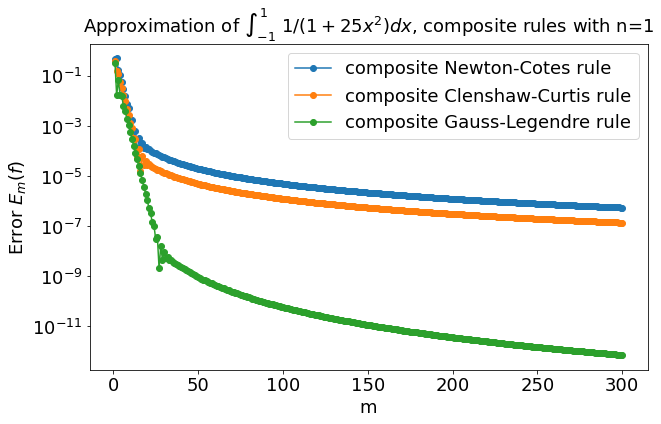

In [35]:
def f_Runge(x):
    return 1/(1+25*x**2)

a = -1
b = 1
I = 2/5 * atan(5) # exact value value the integral

# coefficients on [-1,1] for each elementary rule
n = 1
nodes_elem_NC, weights_elem_NC = coeffs_NewtonCotes(n) 
nodes_elem_CC, weights_elem_CC = coeffs_ClenshawCurtis(n)
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m_max = 300
tab_m = np.arange(1, m_max+1)
# Initialization
tab_IcompNC = np.zeros(m_max)
tab_IcompCC = np.zeros(m_max)
tab_IcompGL = np.zeros(m_max)

# computation of the approximated value of the integral for m = 1,...,m_max
for m in tab_m:
    mesh = np.linspace(a, b, m+1)
    tab_IcompNC[m-1] = QuadRule_composite(f_Runge, mesh, nodes_elem_NC, weights_elem_NC)
    tab_IcompCC[m-1] = QuadRule_composite(f_Runge, mesh, nodes_elem_CC, weights_elem_CC)
    tab_IcompGL[m-1] = QuadRule_composite(f_Runge, mesh, nodes_elem_GL, weights_elem_GL)
    
# computation of the error
tab_errNC = np.abs(tab_IcompNC-I)
tab_errCC = np.abs(tab_IcompCC-I)
tab_errGL = np.abs(tab_IcompGL-I)

# plot
tab_m = tab_m.astype(float)
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_m, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_m, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('Error $E_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-1}^1 \ 1/(1+25x^2) dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()


<div markdown=1 class="DoIt">

What scales did you use for the previous plot? Can you think of a different scale in which one could better understand the behavior of the error? Can you guess how the error behaves with respect to $m$ for each case?

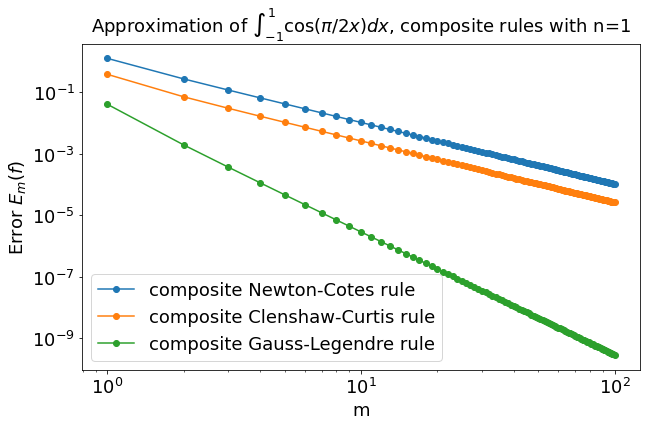

In [41]:
# plot
tab_m = tab_m.astype(float)
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_m, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_m, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('Error $E_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-1}^1 \cos(\pi/2 x) dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.yscale('log')
plt.xscale('log')
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1 class="Answer">

Using a logarithmic scale for both the error and $m$, we get lines in the plot, i.e.

$$
\ln (E_m(f)) \approx \alpha \ln m + \beta,
$$ 

which suggests that we could have

$$
E_m(f) = \frac{C}{m^{-\alpha}}.
$$

Plotting the curves given by $E_m = 1/m^2$ and $E_m = 1/m^4$, it seems that we have $\alpha = 2$
for the Newton-Cotes and Clenshaw-Curtis composite rules, and $\alpha=4$ for the Gauss-Legendre composite rule.

<div markdown=1 class="Rmk">

Here we chose to study the behavior of the error with respect to $m$, but it is also common to look at its behavior with respect to $h$, which can be especially relevant for non-uniform meshes. In our case both viewpoints are fully equivalent since we have the relationship $h=(b-a)/m$, and plots with respect to $h$ can be observed below.

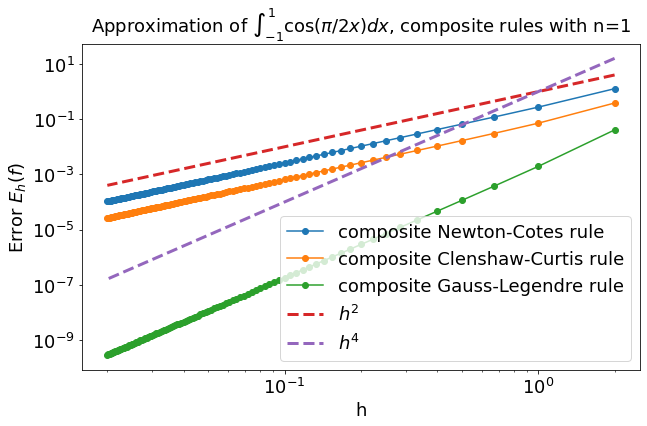

In [42]:
# plot
tab_h = (b-a)/tab_m
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_h, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_h, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_h, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.plot(tab_h, tab_h**2, linestyle="--", linewidth=3, label="$h^2$")
plt.plot(tab_h, tab_h**4, linestyle="--", linewidth=3, label="$h^4$")
plt.xlabel('h', fontsize = 18) 
plt.ylabel('Error $E_h(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-1}^1 \cos(\pi/2 x) dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()

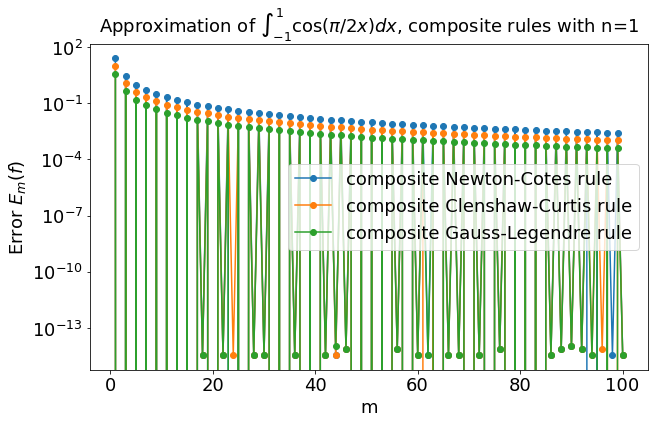

In [96]:
def f(x):
    return  np.abs(x)

a = -5
b = 5
I = 25 # exact value of the integral of f from -1 to 1

# coefficients on [-1,1] for each elementary rule
n = 1
nodes_elem_NC, weights_elem_NC = coeffs_NewtonCotes(n) 
nodes_elem_CC, weights_elem_CC = coeffs_ClenshawCurtis(n)
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m_max = 100
tab_m = np.arange(1, m_max+1)
# Initialization
tab_IcompNC = np.zeros(m_max)
tab_IcompCC = np.zeros(m_max)
tab_IcompGL = np.zeros(m_max)

# computation of the approximated value of the integral for m = 1,...,m_max
for m in tab_m:
    mesh = np.linspace(a, b, m+1)
    tab_IcompNC[m-1] = QuadRule_composite(f, mesh, nodes_elem_NC, weights_elem_NC)
    tab_IcompCC[m-1] = QuadRule_composite(f, mesh, nodes_elem_CC, weights_elem_CC)
    tab_IcompGL[m-1] = QuadRule_composite(f, mesh, nodes_elem_GL, weights_elem_GL)
    
# computation of the error
tab_errNC = np.abs(tab_IcompNC-I)
tab_errCC = np.abs(tab_IcompCC-I)
tab_errGL = np.abs(tab_IcompGL-I)

# plot
tab_m = tab_m.astype(float)
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_m, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_m, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('Error $E_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-1}^1 \cos(\pi/2 x) dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()


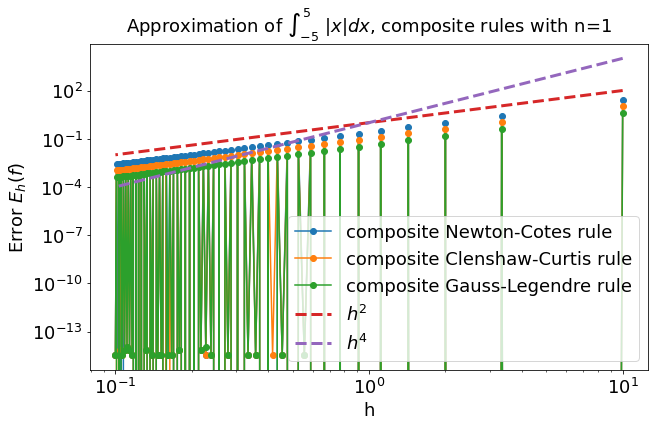

In [98]:
# plot
tab_h = (b-a)/tab_m
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_h, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_h, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_h, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.plot(tab_h, tab_h**2, linestyle="--", linewidth=3, label="$h^2$")
plt.plot(tab_h, tab_h**4, linestyle="--", linewidth=3, label="$h^4$")
plt.xlabel('h', fontsize = 18) 
plt.ylabel('Error $E_h(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-5}^5 \ |x| dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 18)
plt.show()

### Error and rate of convergence

We can prove an error estimate for composite quadrature rules, which confirms the numerical observations made just above, and highlights the importance of the degree of accuracy for composite rules.

<div  markdown=1 class="Thm"> 

**Convergence of composite quadrature rules.** Consider an interval $[a,b]$, a set of $m+1$ mesh points $(x_k)_{0\leq k\leq m}$ such that $a = x_0 < x_1 < \ldots < x_m = b$, an integer $n$, and a composite quadrature rule of the form 

$$
\int_a^b f(x)dx = \sum_{k=0}^{m-1} \int_{x_k}^{x_{k+1}} f(x)dx  \approx \sum_{k=0}^{m-1} I^n_{[x_k,x_{k+1}]}(f).
$$

If the elementary quadrature rule used on each subinterval $[x_k,x_{k+1}]$ has a degree of accuracy of at least $n_a$, and $f\in{\cal C}^{n_a+1}([a,b])$, then there exists a constant $C$ (independent of $m$), such that the error is bounded as follows:

$$
E_m(f) \leq C \sup_{x\in [a,b]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert (b-a) \, h^{n_a+1},
$$

where we recall that 

$$h = \max_{k=0,\ldots,m-1} \left\vert x_{k+1} - x_k \right\vert.$$

> **Proof.** We split the error
>
>\begin{align}
E_m(f) &= \left\vert \int_a^b f(x)dx - \sum_{k=0}^{m-1} I^n_{[x_k,x_{k+1}]}(f) \right\vert \\
&\leq \sum_{k=0}^{m-1} \left\vert \int_{x_k}^{x_{k+1}} f(x)dx - I^n_{[x_k,x_{k+1}]}(f) \right\vert,
\end{align}
>
>and use on each term the error bound for elementary quadrature rules based on the degree of accuracy that we have obtained at the beginning of this chapter, namely
>
>$$
\left\vert \int_{x_k}^{x_{k+1}} f(x)dx - I^n_{[x_k,x_{k+1}]}(f)\,\right\vert \leq C \left(x_{k+1}-x_k\right)^{n_a+2} \sup_{x\in [x_k,x_{k+1}]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert,
$$
>
>where the constant $C$ is given by
>
>$$
C = \frac{2+\sum_{k=0}^n |\omega_k|}{(n_a+1)!2^{n_a+2}}.
$$
>
>Summing all these terms, and using that $\sup_{x\in [x_k,x_{k+1}]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert \leq \sup_{x\in [a,b]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert$, we get
>
>\begin{align}
E_m(f) &\leq C \sup_{x\in [a,b]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert \sum_{k=0}^{m-1} \left(x_{k+1}-x_k\right)^{n_a+2} \\
&\leq C \sup_{x\in [a,b]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert \sum_{k=0}^{m-1} h^{n_a+1}\left(x_{k+1}-x_k\right) \\
&= C \sup_{x\in [a,b]} \left\vert \,f^{(n_a+1)}(x)\,\right\vert (b-a) h^{n_a+1}.
\end{align}

<div markdown=1 class="Rmk">

- The key term in the above error estimation is $h^{n_a+1}$, which tells us at which rate the error goes to $0$ when $h$ goes to $0$. The larger $n_a$ the fastest the convergence, which explains why, for the same value of $n$, we observed a faster convergence with a Gauss-Legendre elementary rule compared to Newton-Cotes or Clenshaw-Curtis.

- In the case of a uniform mesh, where $h=(b-a)/m$, we get 

$$
E_m(f) \leq \frac{C \sup_{x\in [a,b]} \left\vert f^{(n_a+1)}(x)\right\vert (b-a)^{n_a+1}}{m^{n_a+1}}.
$$

- This is a typical case of *sublinear* convergence, as introduced in the first chapter, at least for the error estimator $\beta_m = \frac{C \sup_{x\in [a,b]} \left\vert f^{(n_a+1)}(x)\right\vert (b-a)^{n_a+1}}{m^{n_a+1}}$, since 

$$
\frac{\beta_{m+1}}{\beta_m} \underset{m\to\infty}{\longrightarrow} 1.
$$

<div markdown=1 class="DoIt">

Does the behavior of this error estimate with respect to $m$ match what you observed numerically above for the Newton-Cotes, Clenshaw-Curtis and Gauss-Legendre composite quadrature rules with $n=1$? 

Repeat the same experiment with larger values of $n$.

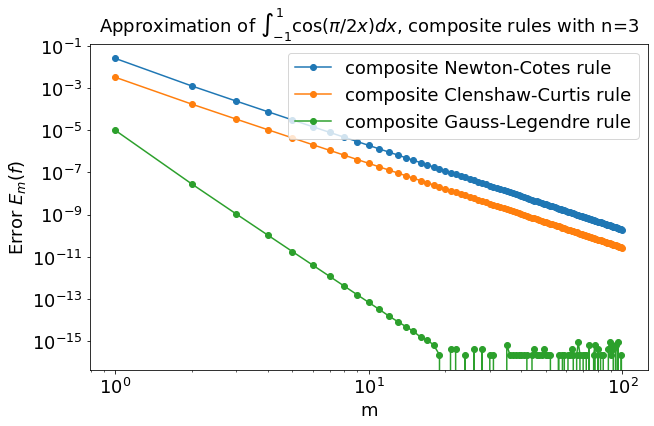

In [59]:
def f(x):
    return  np.cos(pi/2*x)

a = -1
b = 1
I = 4/pi # exact value of the integral of f from -1 to 1

# coefficients on [-1,1] for each elementary rule
n = 3
nodes_elem_NC, weights_elem_NC = coeffs_NewtonCotes(n) 
nodes_elem_CC, weights_elem_CC = coeffs_ClenshawCurtis(n)
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m_max = 100
tab_m = np.arange(1, m_max+1)
# Initialization
tab_IcompNC = np.zeros(m_max)
tab_IcompCC = np.zeros(m_max)
tab_IcompGL = np.zeros(m_max)

# computation of the approximated value of the integral for m = 1,...,m_max
for m in tab_m:
    mesh = np.linspace(a, b, m+1)
    tab_IcompNC[m-1] = QuadRule_composite(f, mesh, nodes_elem_NC, weights_elem_NC)
    tab_IcompCC[m-1] = QuadRule_composite(f, mesh, nodes_elem_CC, weights_elem_CC)
    tab_IcompGL[m-1] = QuadRule_composite(f, mesh, nodes_elem_GL, weights_elem_GL)
    
# computation of the error
tab_errNC = np.abs(tab_IcompNC-I)
tab_errCC = np.abs(tab_IcompCC-I)
tab_errGL = np.abs(tab_IcompGL-I)

# plot
tab_m = tab_m.astype(float)
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_m, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_m, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('Error $E_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int_{-1}^1 \cos(\pi/2 x) dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.yscale('log')
plt.xscale('log')
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1 class="Answer">

For $n=1$ (odd value of $n$), we have seen that the degree of accuracy for Newton-Cotes and Clenshaw-Curtis rules is equal to $1$, and therefore the error estimator decays like $1/m^{n_a+1} = 1/m^2$, which is what we observed. For the Gauss-Legendre rule, we have $n_a=2n+1 = 3$ and so we expect a decay proportional to $1/m^{n_a+1} = 1/m^4$, which is also observed.

Similarly, for $n=2$ (even value of $n$), we have seen that the degree of accuracy for Newton-Cotes and Clenshaw-Curtis rules is equal to $n+1=3$, which explains the decay proportional to $1/m^{n_a+1} = 1/m^4$ observed above. For the Gauss-Legendre rule, we have $n_a=2n+1 = 5$ and so we expect a decay proportional to $1/m^{n_a+1} = 1/m^6$, which is also observed.


<div markdown=1 class="DoIt">

Use composite quadrature rules to approximate $\int_0^1 \sqrt{x} dx$, and study numerically the behavior of the error with respect to $m$. Comment on the obtained results.

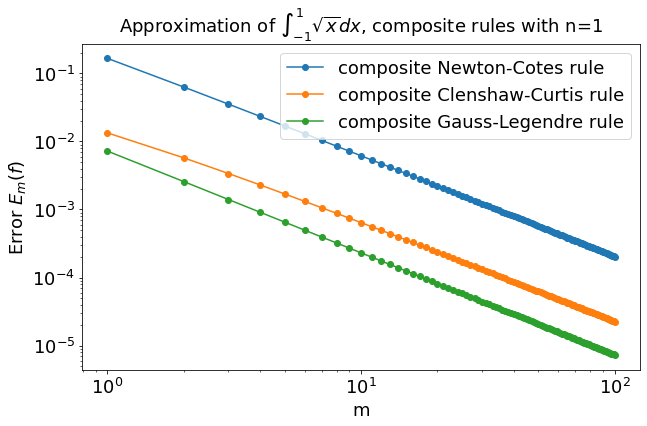

In [61]:
def f(x):
    return  np.sqrt(x)

a = 0
b = 1
I = 2/3 # exact value of the integral of f from 0 to 1


# coefficients on [-1,1] for each elementary rule
n = 1
nodes_elem_NC, weights_elem_NC = coeffs_NewtonCotes(n) 
nodes_elem_CC, weights_elem_CC = coeffs_ClenshawCurtis(n)
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m_max = 100
tab_m = np.arange(1, m_max+1)
# Initialization
tab_IcompNC = np.zeros(m_max)
tab_IcompCC = np.zeros(m_max)
tab_IcompGL = np.zeros(m_max)

# computation of the approximated value of the integral for m = 1,...,m_max
for m in tab_m:
    mesh = np.linspace(a, b, m+1)
    tab_IcompNC[m-1] = QuadRule_composite(f, mesh, nodes_elem_NC, weights_elem_NC)
    tab_IcompCC[m-1] = QuadRule_composite(f, mesh, nodes_elem_CC, weights_elem_CC)
    tab_IcompGL[m-1] = QuadRule_composite(f, mesh, nodes_elem_GL, weights_elem_GL)
    
# computation of the error
tab_errNC = np.abs(tab_IcompNC-I)
tab_errCC = np.abs(tab_IcompCC-I)
tab_errGL = np.abs(tab_IcompGL-I)

# plot
tab_m = tab_m.astype(float)
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_errNC, marker="o", label="composite Newton-Cotes rule")
plt.plot(tab_m, tab_errCC, marker="o", label="composite Clenshaw-Curtis rule")
plt.plot(tab_m, tab_errGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('Error $E_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $\int ^{1}_{-1} {\sqrt {x}}dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.yscale('log')
plt.xscale('log')
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1 class="Answer">

The function $\sqrt{\ }$ is not $C^1$, and therefore the error estimates that we have seen do not apply. Indeed, we observe that the error only decays like $1/m^{3/2}$, even when the degree of accuracy of the elementary rule used is larger than $0$.

**Conclusions**

If we do not want to use quadrature rules with a large degree $n$, composite quadrature rules offer a good alternative. For composite rules, the rate of convergence is really dictated by the degree of accuracy of the elementary rule used (provided the function that is integrated is smooth enough).

<a id="MC"></a>
## A non-deterministic approach 非确定性算法，蒙特卡洛算法

<img src="figures/Metropolis.png" alt="Metropolis" style="width: 170px;" />

>**Nicholas Constantine Metropolis (1915 - 1999).**
> Nicholas Constantine Metropolis is a Greek-American physicist. In the 1950s, a group of researchers led by Metropolis, including John von Neumann and Stanislaw Ulam, developed the Monte Carlo method. This term describes a broad class of algorithms relying on random sampling. The basic idea is to use randomness to solve deterministic problems. These kind of methods are now widely used, for instance in optimization, integration and probability.

### In dimension 1

Suppose you want to compute $\int_a^b f(x)dx$. The Monte-Carlo approach simply consists in taking $n$ random points $x_1,\ldots,x_n$ distributed uniformly in $[a,b]$, and approximating the integral by the average of $(b-a)f(x_k)$:

$$
MC^n_{[a,b]}(f) = \frac{b-a}{n} \sum_{k=1}^n f(x_k).
$$

Stating and proving precise results about the behavior of the Monte-Carlo approach when $n$ goes to infinity requires some knowledge in probability theory which is beyond the scope of this course, but roughly speaking we can say the following.

<div markdown=1 class='Thm'>

- $MC^n_{[a,b]}(f)$ converges to $\int_a^b f(x) dx$ when $n$ goes to infinity.

- The error $\left\vert MC^n_{[a,b]}(f) - \int_a^b f(x) dx \right\vert$ scales roughly like $\frac{C}{\sqrt{n}}$. 

<div markdown=1, class="Fur">[$\star$]

The key underlying results from probability theory are **the law of large numbers** and **the central limit theorem**.

<div markdown=1, class="DoIt">

Complete the following cell, to get a function which computes $MC^n_{[a,b]}(f)$.

In [52]:
def MonteCarlo(f, a, b, n):
    """
    Approximate 1d integral using the Monte-Carlo approach
    -----------------------------------------
    Inputs :
    f: function of one variable to be integrated
    a, b: endpoints of the segment on which the integral is computed
    n: number of points
    
    Output
    the approximate value of \int_{a}^{b} f obtained using the Monte-Carlo approach
    """
    x = a+(b-a)*np.random.rand(n) # n random points uniformly distributed in [a,b]
    return np.sum(f(x))*(b-a)/n

<div markdown=1, class="DoIt">

Run the following cell, which uses the function `MonteCarlo` to study graphically the converge of the Monte-Carlo method. Try different functions. Comment on the obtained results.

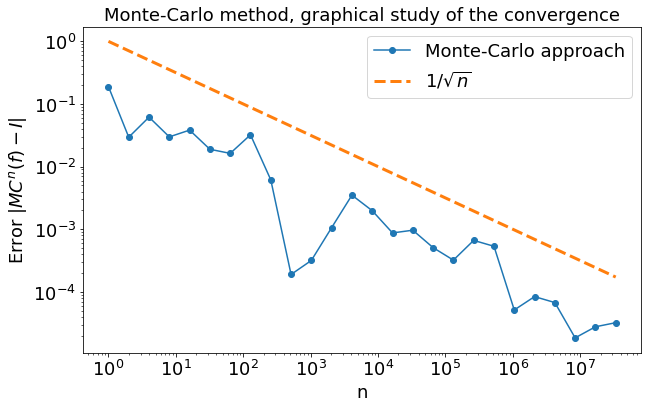

In [55]:
# # case 1
# def f(x):
#     return  np.cos(pi/2*x)
# a = -1
# b = 1
# I = 4/pi # exact value of the integral of f from -1 to 1

# case 2
def f(x):
    return 1/(1+x**2)
a = 0
b = 1
I = pi/4 # exact value of the integral of f from 0 to 1

# # case 3
# def f(x):
#     return  1/(1+25*x**2)
# a = -1
# b = 1
# I = 2/5*atan(5) # exact value of the integral of f from -1 to 1

# # case 4
# def f(x):
#     return  np.sqrt(x)
# a = 0
# b = 1
# I = 2/3 # exact value of the integral of f from 0 to 1

exp_max = 25
tab_n = 2**np.arange(0, exp_max+1) # values of n between 2^0 and 2^{exp_max}
tab_MCn = np.zeros(tab_n.size) # initialization for the approximate values

i = 0
for n in tab_n:
    tab_MCn[i] = MonteCarlo(f, a, b, n)
    i = i + 1
    
tab_err = np.abs(tab_MCn-I) # Error

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_err, marker="o", label="Monte-Carlo approach")
plt.plot(tab_n, 1/tab_n**(1/2), linestyle="--", linewidth=3, label="$1/\sqrt{n}$")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| MC^n(f) - I |$', fontsize = 18)
plt.legend(fontsize = 18)
plt.xscale('log')
plt.yscale('log')
plt.title('Monte-Carlo method, graphical study of the convergence', fontsize = 18)
plt.tick_params(labelsize = 18)
plt.show()


<div markdown=1, class="Answer">

There are some fluctuations, which are to be expected since the method is of probabilistic nature, but we indeed seem to roughly recover the $\frac{1}{\sqrt{n}}$ convergence rate, independently of the function chosen.

### In higher dimension

Consider a bounded subset $B\subset \mathbb{R}^d$, $d\geq 1$, and suppose you want to compute $\int_B f(x,y)dxdy$. The Monte-Carlo approach naturally extends to this higher dimensional case, again by taking $n$ random points $(x_1,y_1),\ldots,(x_n,y_n)$ distributed uniformly in $B$, and then averaging the $f(x_k)$.

In practice, directly obtaining random samples uniformly in $B$ might not be very easy (depending on the set $B$). However, there is a simple workaround, that we describe here in dimension $d=2$ (the generalization to higher dimensions is straightforward). Let $a_1,a_2,b_1,b_2$ be such that 

$$
B \subset [a_1,b_1]\times[a_2,b_2].
$$

Then,

$$
\int_{B} f(x,y)dx dx = \int_{[a_1,b_1]\times[a_2,b_2]} f(x,y) \mathbb{1}_{B} (x,y) dx dy,
$$

where $\mathbb{1}_{B}$ is the **indicator function** of $B$, defined as

$$
\mathbb{1}_{B}(x,y) = 
\left\{
\begin{aligned}
&1 \qquad &(x,y)\in B, \\
&0 \qquad &(x,y)\notin B.
\end{aligned}
\right.
$$

We can then easily apply the Monte-Carlo approach to

$$
\int_{[a_1,b_1]\times[a_2,b_2]} \tilde f(x,y) dx dy,
$$

where $\tilde f(x,y) = f(x,y) \mathbb{1}_{B} (x,y)$:

$$
MC^n_{[a_1,b_1]\times[a_2,b_2]}(\tilde f) = \frac{(b_1-a_1)(b_2-a_2)}{n} \sum_{k=1}^n \tilde f(x_k,y_k),
$$

with random points $x_1,\ldots,x_n$ distributed uniformly in $[a_1,b_1]$, and random points $y_1,\ldots,y_n$ distributed uniformly in $[a_2,b_2]$.

<div markdown=1, class="Rmk">

- A similar strategy can in fact be used to construct random samples uniformly distributed in $B$: consider random points $(x_k,y_k)$ uniformly distributed in $[a_1,b_1]\times[a_2,b_2]$, and only keep those who belong to $B$.
- This is exactly what the indicator function $\mathbb{1}_{B}$ does, i.e. keeping only the samples which are inside $B$.
- This suggests that, in practice, we want $[a_1,b_1]\times[a_2,b_2]$ to be as small as possible while containing $B$. Indeed, the larger $[a_1,b_1]\times[a_2,b_2]$, the more likely we are to get *useless* samples $(x_k,y_k)$ which are outside of $B$ and have to be dropped.
- If the function $f$ is equal to $1$, $\int_B f(x) dx$ is nothing but the area of $B$. The Monte-Carlo approach therefore provides us with a way of approximating areas.

Regarding the converge, the results are the same as in dimension 1 (again stated somewhat imprecisely).

<div markdown=1 class='Thm'>


- $MC^n_{[a_1,b_1]\times[a_2,b_2]}(f)$ converges to $\int_{[a_1,b_1]\times[a_2,b_2]} f(x,y) dxdy$ when $n$ goes to infinity.


- The error $\left\vert MC^n_{[a_1,b_1]\times[a_2,b_2]}(f) - \int_{[a_1,b_1]\times[a_2,b_2]} f(x,y) dxdy \right\vert$ scales roughly like $\frac{C}{\sqrt{n}}$. 

<div markdown=1, class="Rmk">

- It is remarkable that we need only $n$ samples, as in dimension 1, to get the same scaling for the error, and that this scaling does not require any smoothness assumption on $f$.

- The same cannot be said for the quadrature rules that we have seen previously. Indeed, they cannot be as easily generalized to higher dimensions, especially when the domain $B$ is not a rectangle. Even then, the number $n$ of samples needed becomes $n^d$ in dimension $d$, which can become prohibitive, whereas Monte-Carlo's approach requires $n$ samples to get an error of $\frac{C}{\sqrt{n}}$ independently of the dimension.

<div markdown=1, class="DoIt">

Complete the following cell, to get a function which computes the Monte-Carlo approximation $MC^n_{[a_1,b_1]\times[a_2,b_2]}(f)$ on a rectangle.

In [56]:
def MonteCarlo_2D(f, a, b, n):
    """
    Approximate 2d integral on a rectangle using the Monte-Carlo approach
    -----------------------------------------
    Inputs :
    f: function of two variables to be integrated
    a, b: arrays a=[a_1,a_2] and b=[b_1,b_2] endpoints of the rectangle on which the integral is computed
    n: number of points
    
    Output
    the approximate value of \int_{[a_1,b_1]x[a_2,b_2]} f obtained using the Monte-Carlo approach
    """
    x = a[0]+(b[0]-a[0])*np.random.rand(n) # first coordinate, uniformly distributed in [a_1,b_1]
    y = a[1]+(b[1]-a[1])*np.random.rand(n) # second coordinate, uniformly distributed in [a_2,b_2]
    return np.sum(f(x,y))*(b[1]-a[1])*(b[0]-a[0])/n

<div markdown=1, class="DoIt">

Run the following cell, which uses the function `MonteCarlo_2D`, to approximate the area of the unit disk. Compare and comment on the behavior on the error when the rectangle $[a_1,a_2]\times[b_1,b_2]$ changes.

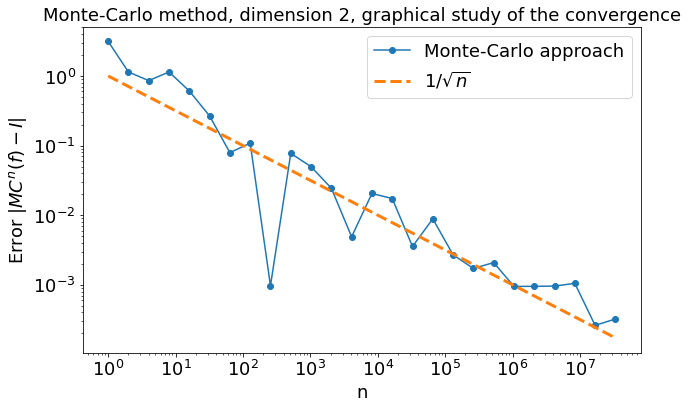

In [57]:
def Ind_disk(x,y): # indicator function of the unit disk
    z = x**2+y**2 < 1
    return z.astype(int) # converts True/False to 1/0

a = np.array([-1,-1]) # a_1 and a_2
b = np.array([1,1]) # b_1 and b_2
I = pi # exact value of the area of the unit disk

exp_max = 25
tab_n = 2**np.arange(0, exp_max+1) # values of n between 2^0 and 2^{exp_max}
tab_MCn = np.zeros(tab_n.size) # initialization for the approximate values

i = 0
for n in tab_n:
    tab_MCn[i] = MonteCarlo_2D(Ind_disk, a, b, n)
    i = i + 1
    
tab_err = np.abs(tab_MCn-I) # Error

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_err, marker="o", label="Monte-Carlo approach")
plt.plot(tab_n, 1/tab_n**(1/2), linestyle="--", linewidth=3, label="$1/\sqrt{n}$")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| MC^n(f) - I |$', fontsize = 18)
plt.legend(fontsize = 18)
plt.xscale('log')
plt.yscale('log')
plt.title('Monte-Carlo method, dimension 2, graphical study of the convergence', fontsize = 18)
plt.tick_params(labelsize = 18)
plt.show()

<div markdown=1, class="Answer">

The error always decays roughly like $\frac{C}{\sqrt{n}}$, as predicted, but it seems that a larger rectangle $[a_1,a_2]\times[b_1,b_2]$ leads to a larger constant $C$.

<a id="CS"></a>
## Back to the case studies [$\star$]

### Case Study 1: Manufacturing a corrugated roofing.

We recall we need to compute the following elliptic integral:

$$ l = \int_{0}^{48} \sqrt{1 + cos^2(x)}dx$$.

<div markdown=1, class="DoIt">

Compute this integral with the method of your choice. How confident are you in the results?

We compare the results obtained using either an elementary Gauss-Legendre quadrature with a large number of nodes, or a composite Gauss-Legendre rule.

In [58]:
def function_l(x):
    return np.sqrt(1+np.cos(x)**2)

a = 0
b = 48

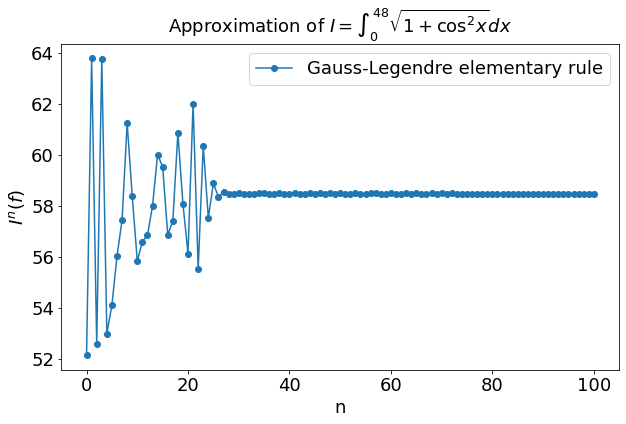

In [60]:
#Elementary Gauss-Legendre rule

nmax = 100
tab_n = np.arange(0, nmax+1)
tab_InGL = np.zeros(nmax+1)

# computation of the approximated value of the integral for n = 0,...,nmax
for n in tab_n:  
    x_nGL, w_nGL = coeffs_GaussLegendre(n) # coefficients for the rule on [-1,1]
    x_nGL = a + (b-a)/2 * (x_nGL+1) # rescaled nodes on [a,b]
    w_nGL = (b-a)/2 * w_nGL # rescaled weights on [a,b]
    tab_InGL[n] = QuadRule(function_l, x_nGL, w_nGL)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_n, tab_InGL, marker="o", label="Gauss-Legendre elementary rule")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('$I^n(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $ I = \int_{0}^{48} \sqrt{1+\cos^2x} dx$', fontsize = 18) 
plt.tick_params(labelsize = 18)
plt.show()

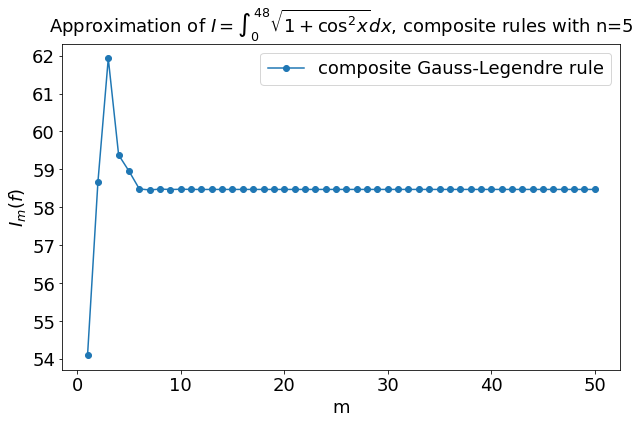

In [62]:
#Composite Gauss-Legendre rule

n = 5 # degree of the elementary rule used
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m_max = 50
tab_m = np.arange(1, m_max+1)
tab_IcompGL = np.zeros(m_max)

# computation of the approximated value of the integral for m = 1,...,nmax
for m in tab_m:
    mesh = np.linspace(a, b, m+1) # subdivision of [a,b] into m subintervals
    tab_IcompGL[m-1] = QuadRule_composite(function_l, mesh, nodes_elem_GL, weights_elem_GL)

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_m, tab_IcompGL, marker="o", label="composite Gauss-Legendre rule")
plt.xlabel('m', fontsize = 18) 
plt.ylabel('$I_m(f)$', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Approximation of $ I = \int_{0}^{48} \sqrt{1+\cos^2x} dx$, composite rules with n=%s'%n, fontsize = 18) 
plt.tick_params(labelsize = 18)
plt.show()

In [65]:
# Comparison

# elementary
n = 500
x_nGL, w_nGL = coeffs_GaussLegendre(n) # coefficients for the rule on [-1,1]
x_nGL = a + (b-a)/2 * (x_nGL+1) # rescaled nodes on [a,b]
w_nGL = (b-a)/2 * w_nGL # rescaled weights on [a,b]
I500GL = QuadRule(function_l, x_nGL, w_nGL)

n = 1000
x_nGL, w_nGL = coeffs_GaussLegendre(n) # coefficients for the rule on [-1,1]
x_nGL = a + (b-a)/2 * (x_nGL+1) # rescaled nodes on [a,b]
w_nGL = (b-a)/2 * w_nGL # rescaled weights on [a,b]
I1000GL = QuadRule(function_l, x_nGL, w_nGL)

# composite
n = 5 # degree of the elementary rule used
nodes_elem_GL, weights_elem_GL = coeffs_GaussLegendre(n)

m = 100
mesh = np.linspace(a, b, m+1) # subdivision of [a,b] into m subintervals
Icomp100GL = QuadRule_composite(function_l, mesh, nodes_elem_GL, weights_elem_GL)

m = 200
mesh = np.linspace(a, b, m+1) # subdivision of [a,b] into m subintervals
Icomp200GL = QuadRule_composite(function_l, mesh, nodes_elem_GL, weights_elem_GL)

print(I500GL)
print(I1000GL)
print(Icomp100GL)
print(Icomp200GL)

58.470469154898964
58.470469154899604
58.47046915489897
58.470469154899334


<div markdown=1, class="Rmk">

For the composite rule, we could have gotten an error estimate (not taking into account rounding errors), by using the formula

$$
E_m(f) \leq \frac{C \sup_{x\in [a,b]} \left\vert f^{(n_a+1)}(x)\right\vert (b-a)^{n_a+1}}{m^{n_a+1}},
$$

with $C = \frac{4}{(n_a+1)!2^{n_a+2}}$ and the appropriate value of the degree of accuracy $n_a$, but this requires to compute, and bound, the derivative of order $n_a+1$ of $f(x) = \sqrt{1+\cos^2 x}$.

### Case Study 2: length of a race track

We recall we want to estimate the integral of a speed function $v$

$$
\text{Length} = \int_0^{84} v(t)dt,
$$

and that $v$ is known only at some discrete points:

In [67]:
time = np.linspace(0,84,15)
speed = np.array([124, 134, 148, 156, 147, 133, 180, 109, 99, 85, 78, 89, 104, 116, 123])
print('The times at which the speed was measured:', time)
print('The speed at each of these times:', speed)

The times at which the speed was measured: [ 0.  6. 12. 18. 24. 30. 36. 42. 48. 54. 60. 66. 72. 78. 84.]
The speed at each of these times: [124 134 148 156 147 133 180 109  99  85  78  89 104 116 123]


<div markdown=1, class="DoIt">

Compute the length of the track with the method of your choice. How confident are you in the results?

<div markdown=1, class="Answer">

Here the nodes (i.e. the times at which the speed $v$ is evaluated is measured) are fixed and equidistant, therefore we have less choices.

One could use an elementary Newton-Cotes rule of degree 14, taking into account all the points, but we saw that such rule could be unstable when the degree was 8 or more. Indeed this is not a good idea, since the output below, which should be an approximation of the total length of the track, is negative...

In [68]:
# Elementary Newton-Cotes rule of degree 14
n = 14
x_nNC, w_nNC = coeffs_NewtonCotes(n) # coefficients for the rule on [-1,1]

a = 0
b = 84
w_nNC = (b-a)/2 * w_nNC # rescaled weights on [a,b]

I14NC = np.sum(speed * w_nNC) # the values in speed correspond to the v(x_k) for 14+1 equidistant nodes x_k
print(I14NC) 

-7255.210134634567


<div markdown=1, class="Answer">

Here are some other options:
- Using only half the points, so that the corresponding elementary Newton-Cotes is only of degree 7 and therefore stable.
- If we do not want to forget some of the data, we can use elementary quadrature rules. In that case, given the data there are several possible combinations of degree $n$ and number of subintervals $m$.

We explore both options below.

In [81]:
# Elementary Newton-Cotes rule of degree 7, using only each other point
n = 7
x_nNC, w_nNC = coeffs_NewtonCotes(n) # coefficients for the rule on [-1,1]

a = 0
b = 84
w_nNC = (b-a)/2 * w_nNC # rescaled weights on [a,b]

I7NC = np.sum(speed[0::2] * w_nNC) # the values in speed correspond to the v(x_k) for 7+1 equidistant nodes x_k
print(I7NC) 

10784.409027777778


In [82]:
# Composite Newton-Cotes rule of degree n=7, m=2 subintervals
n = 7
x_nNC, w_nNC = coeffs_NewtonCotes(n) # coefficients for the rule on [-1,1]

a = 0
b = 84
w_nNC = (b-a)/4 * w_nNC # rescaled weights on half the interval

I7compNC = np.sum(speed[0:8] * w_nNC) + np.sum(speed[7:16] * w_nNC)
print(I7compNC) 

10373.824999999999


In [71]:
# Composite Newton-Cotes rule of degree n=1 (trapezoidal rule), m=14 subintervals
a = 0
b = 84

m = 14
I1compNC = (b-a)/m * np.sum((speed[0:-1]+speed[1:])/2)
print(I1compNC)

10209.0


<div markdown=1, class="Answer">

At least all the answers are now positive, and it seems that the total length is somewhere between 10000 and 11000 feet, but it is not possible to give a very precise approximation without additional data.

### Case study 3: Computing volumes of solids

We recall that we want to compute the volume of solids $B$ of the form

$$
B = \left\{ (x,y,z)\in\mathbb{R}^3,\  \left(\left|\frac{x}{a}\right|^{\frac{2}{e}}+\left|\frac{y}{b}\right|^{\frac{2}{e}}\right)^{\frac{e}{n}}+\left|\frac{z}{c}\right|^{\frac{2}{n}}\leq 1 \right\}.
$$

In the following cell, we give a function which can be used to visualize such super-ellipsoid $B$, based on parametric equations of the boundary, given by

$$\left\{\begin{array}{l}
x(u,v)=a\, |cos(u)|^e \,|sin(v)|^n \,sign(cos(u)) \,sign(sin(v))\\
y(u,v)=b \,|sin(u)|^e \,|sin(v)|^n \,sign(sin(u)) \,sign(sin(v))\\
z(u,v)=c \,|cos(v)|^n \,sign(cos(v))
\end{array}
\right.
$$

for $u\in[0,\pi]$ and $v\in[0,2\pi]$.

In [72]:
# Function to plot a super-ellipsoid
# inputs: parameters e (real>0), n (real>0), a (real>0), b (real>0), c (real>0) of the super-ellipsoid

def plot_superellipsoid(e,n,a,b,c):
    "Parametric surface S: (u,v)->((x(u,v),y(u,v),z(u,v))"
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm  # for the color map

    fig = plt.figure(figsize=(10, 6))
    trace1 =  fig.add_subplot(111, projection='3d')

    N = 100
    Dx = np.linspace(0, np.pi, N)
    Dy = np.linspace(0, 2*np.pi, 2*N)

    # Computations of x, y, z
    x = np.asarray([[a*abs(cos(u))**e*abs(sin(v))**n*copysign(1,cos(u))*copysign(1,sin(v)) for v in Dy] for u in Dx])
    y = np.asarray([[b*abs(sin(u))**e*abs(sin(v))**n*copysign(1,sin(u))*copysign(1,sin(v)) for v in Dy] for u in Dx])
    z = np.asarray([[c*abs(cos(v))**n*copysign(1,cos(v)) for v in Dy] for u in Dx])

    # Surface generation
    #  rstride et  cstride to plot a sub-mesh of Dx x Dy
    trace1.plot_surface(x, y, z, rstride = 4, cstride=4, cmap = cm.winter)
    #plt.axis('equal')
    #plt.axis('off')
    plt.title(r"Super Ellipsoid $(|x/a|^{\frac{2}{e}}+|y/b|^{\frac{2}{e}})^{\frac{e}{n}}+|z/c|^{\frac{2}{n}}\leq 1$", fontsize = 20)
    plt.show()

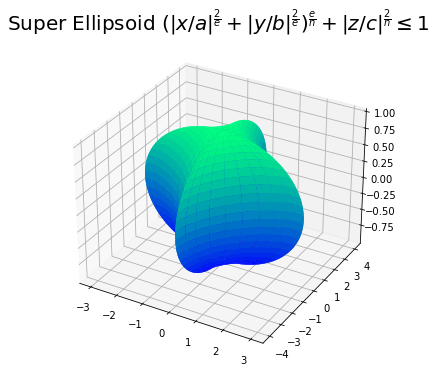

In [73]:
e = 3
n = 1
a = 3
b = 4
c = 1

# e = 2
# n = 3
# a = 1
# b = 1
# c = 1

plot_superellipsoid(e,n,a,b,c)

<div markdown=1, class="DoIt">

Use the method of your choice to compute the volume of such solids.

<div markdown=1, class="Answer">

Given that the problem is in dimension 3, we use the Monte-Carlo approach. We first try the algorithm on cases where $n=e=1$, because we then have an explicit formula for the volume given in the introduction ($\frac{4}{3}\pi abc$), which allows us to test our code. 

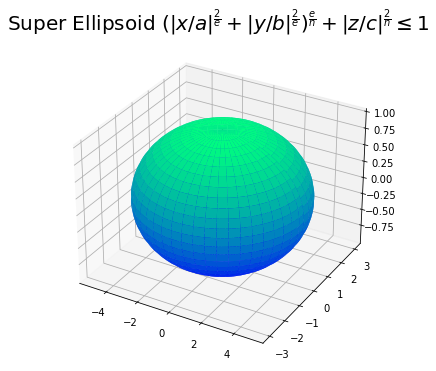

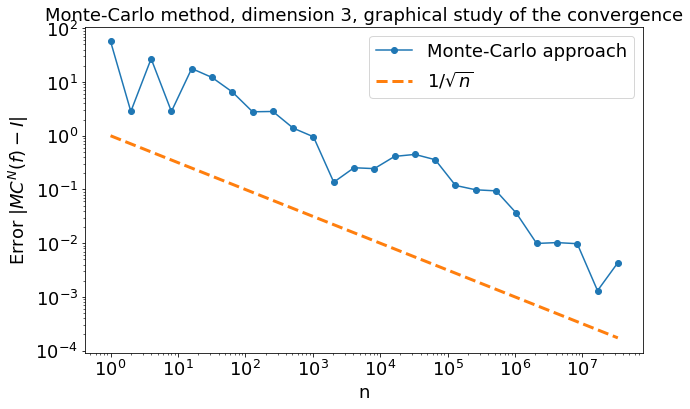

In [74]:
def MonteCarlo_3D(f, a, b, n):
    """
    Approximate 3d integral on a rectangular cuboid using the Monte-Carlo approach
    -----------------------------------------
    Inputs :
    f: function of three variables to be integrated
    a, b: arrays a=[a_1,a_2,a_3] and b=[b_1,b_2,b_3] endpoints of the rectangular cuboid on which the integral is computed
    n: number of points
    
    Output
    the approximate value of \int_{[a_1,b_1]x[a_2,b_2]x[a_3,b_3]} f obtained using the Monte-Carlo approach
    """
    x = a[0] + (b[0]-a[0]) * np.random.rand(n) # first coordinate, uniformly distributed in [a_1,b_1]
    y = a[1] + (b[1]-a[1]) * np.random.rand(n) # second coordinate, uniformly distributed in [a_2,b_2]
    z = a[2] + (b[2]-a[2]) * np.random.rand(n) # second coordinate, uniformly distributed in [a_2,b_2]
    return np.sum(f(x, y, z)) * (b[0]-a[0])*(b[1]-a[1])*(b[2]-a[2])/n

#Test case with a "regular" ellipsoid (e=n=1)
e=1
n=1
a=5
b=3
c=1

plot_superellipsoid(e,n,a,b,c)

I = 4/3*pi*a*b*c # exact value of the volume of the solid, valid only if e=n=1

def Ind_B(x,y,z): # indicator function of the unit disk
    test = ( np.abs(x/a)**(2/e) + np.abs(y/b)**(2/e) )**(e/n) + np.abs(z/c)**(2/n) < 1
    return test.astype(int) # converts True/False to 1/0

# Boundary for the rectangular cuboid
a_cuboid = np.array([-a,-b,-c]) 
b_cuboid = np.array([a,b,c]) 

exp_max = 25
tab_N = 2**np.arange(0, exp_max+1) # values of n between 2^0 and 2^{exp_max}
tab_MCN = np.zeros(tab_N.size) # initialization for the approximate values

i = 0
for N in tab_N:
    tab_MCN[i] = MonteCarlo_3D(Ind_B, a_cuboid, b_cuboid, N)
    i = i + 1
    
tab_err = np.abs(tab_MCN-I) # Error

# plot
fig = plt.figure(figsize=(10, 6))
plt.plot(tab_N, tab_err, marker="o", label="Monte-Carlo approach")
plt.plot(tab_N, 1/tab_N**(1/2), linestyle="--", linewidth=3, label="$1/\sqrt{n}$")
plt.xlabel('n', fontsize = 18) 
plt.ylabel('Error $| MC^N(f) - I |$', fontsize = 18)
plt.legend(fontsize = 18)
plt.xscale('log')
plt.yscale('log')
plt.title('Monte-Carlo method, dimension 3, graphical study of the convergence', fontsize = 18)
plt.tick_params(labelsize = 18)
plt.show()

We observe the expected convergence in a case where we have an explicit formula to which we can compare the output of our algorithm, and are now ready to use our algorithm in other cases.

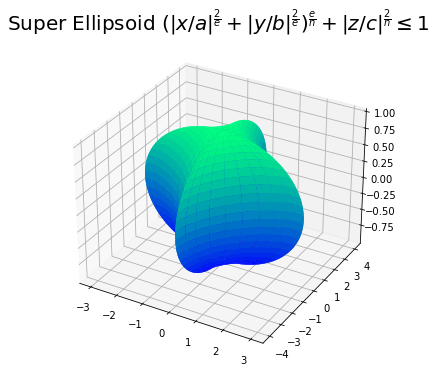

N = 1.000000e+07
Approximate volume = 18.831187


In [75]:
# parameters
e = 3
n = 1
a = 3
b = 4
c = 1

# e = 2
# n = 3
# a = 1
# b = 1
# c = 1

plot_superellipsoid(e,n,a,b,c)


def Ind_B(x,y,z): # indicator function of the unit disk
    test = ( np.abs(x/a)**(2/e) + np.abs(y/b)**(2/e) )**(e/n) + np.abs(z/c)**(2/n) < 1
    return test.astype(int) # converts True/False to 1/0

# Boundary for the rectangular cuboid
a_cuboid = np.array([-a,-b,-c]) 
b_cuboid = np.array([a,b,c]) 

N = 10**7
Approx = MonteCarlo_3D(Ind_B, a_cuboid, b_cuboid, N)

print("N = %e" %N)
print("Approximate volume = %f" %Approx)

In [2]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style/custom3.css").read()
    return HTML(styles)
css_styling()

#### Assume we want to approximate $\int_{0}^{1}\left(x^{7}-x+1\right) d x$, using the elementary Newton-Cotes quadrature rule with $𝑛=7$ (i.e. with 8 equidistant nodes). Which value would we obtain?

In [86]:
def function1(x):
    return x**7-x+1

a = 0
b = 1

n = 7
x_nNC, w_nNC = coeffs_NewtonCotes(n) # coefficients for the rule on [-1,1]
x_nNC = (x_nNC+1)/2
w_nNC = (b-a)/2 * w_nNC # rescaled weights on half the interval
print(x_nNC, w_nNC)


result = QuadRule(function1, x_nNC, w_nNC)
print('The value of the integration is', result)

[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ] [0.04346065 0.20700231 0.0765625  0.17297454 0.17297454 0.0765625
 0.20700231 0.04346065]
The value of the integration is 0.625
